# TCGA-UCEC – Notebook 0C (Sections 1-5)
## ML Preprocessing : Target & Variables (Génomiques + Cliniques)

- **Section 1** : Configuration & Environnement
- **Section 2** : Chargement Données
- **Section 3** : Target Engineering (OS 5 ans) + Audit Temporalité + Intégration Variables Cliniques (FIGO + Grade)
- **Section 4** : Synthèse (Cohorte & Stratégie ML)
- **Section 5** : Préprocessing MLP (Supervised)
- **Section 6** : Préprocessing Autoencodeur (Unsupervised)

---
# 1. Configuration et Environnement

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from scipy.stats import mannwhitneyu, chi2_contingency, spearmanr
from sklearn.manifold import TSNE
import umap
from lifelines import KaplanMeierFitter
import warnings
from datetime import datetime

warnings.filterwarnings("ignore")

# Configuration projet
PROJECT_ROOT = os.getcwd()

DIRS = {
    "RAW": os.path.join(PROJECT_ROOT, "data", "raw"),
    "PROCESSED": os.path.join(PROJECT_ROOT, "data", "processed"),
    "NORM": os.path.join(PROJECT_ROOT, "data", "processed", "normalized"),
    "ML_READY": os.path.join(PROJECT_ROOT, "data", "processed", "ml_ready"),
    "SURVIVAL": os.path.join(PROJECT_ROOT, "data", "artefacts", "survival_analysis"),
    "FEATURES": os.path.join(PROJECT_ROOT, "data", "artefacts", "feature_selection"),
    "AUDIT": os.path.join(PROJECT_ROOT, "data", "audit")
}

for path in DIRS.values():
    os.makedirs(path, exist_ok=True)

# Configuration graphiques
plt.rcParams["figure.dpi"] = 100
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["font.size"] = 11
sns.set_theme(style="whitegrid", palette="Set2")

print(f"✅ Environnement chargé. Racine : {PROJECT_ROOT}")

✅ Environnement chargé. Racine : c:\Z\M2_AIDA\TCGA_UCEC_project


---
# 2. Chargement des données

In [2]:
df_expr = pd.read_csv(os.path.join(DIRS['NORM'], 'expr_norm_filtered.csv.gz'), 
                      index_col=0, compression='gzip')
print(f" ✅ Expression génique    : {df_expr.shape[0]} échantillons × {df_expr.shape[1]} gènes   > Patientes uniques (Expression) : {df_expr.index.nunique()}")

df_clin = pd.read_csv(os.path.join(DIRS['RAW'], 'metadata_clinical_merged.csv.gz'), 
                      index_col=0, compression='gzip')
print(f" ✅ Métadonnées cliniques : {df_clin.shape[0]} échantillons × {df_clin.shape[1]} variables > Patientes uniques (Clinique)   : {df_clin.index.nunique()}")

assert (df_expr.index == df_clin.index).all(), "❌ Index désalignés"
print(f" ✅ Index alignés (Expression versus Clinique)")

 ✅ Expression génique    : 553 échantillons × 21168 gènes   > Patientes uniques (Expression) : 553
 ✅ Métadonnées cliniques : 553 échantillons × 175 variables > Patientes uniques (Clinique)   : 553
 ✅ Index alignés (Expression versus Clinique)


---
# 3. Target Engineering : Overall Survival 5 ans (OS 5y)

## Préambule méthodologique : Sélection des Variables $y$ (Cible) et $X$ (Features)

### 1. Variable Cible ($y$) : Survie Globale à 5 ans
- **Définition** : L'OS 5 ans est retenue comme critère de jugement principal, car elle constitue le standard oncologique pour évaluer la rémission.
- **Justification** : Ce seuil de 1825 jours permet de segmenter deux populations aux profils de survie statistiquement distincts ($p < 0.001$).
- **Faisabilité** : Le dataset présente des classes équilibrées (56% survie vs 44% décès), ce qui constitue une condition optimale pour l'apprentissage profond.
- **Préférence vs Récidive** : Bien que la récidive soit corrélée à la survie ($\rho = 0.39$), l'OS 5 ans est préférée comme target car : (1) elle représente le gold standard oncologique (endpoint final), (2) elle évite la censure ambiguë de la récidive (68.5% complétude avec confusion entre absence réelle et perte de vue), (3) elle offre une mesure objective et non ambiguë (vivant/décédé).

### 2. Variables Prédictives ($X$) : Modèle Hybride Multimodal
L'approche combine des données cliniques et moléculaires disponibles exclusivement au diagnostic (T0) :
- **Volet Clinique** : Intégration du Stade FIGO (encodage One-Hot) et du Grade tumoral (encodage Ordinal).
- **Volet Génomique** : Utilisation du transcriptome filtré par tests statistiques de Mann-Whitney.
- **Complémentarité** : L'absence de colinéarité excessive ($|\rho| < 0.7$) entre les gènes et le grade confirme que ces modalités apportent des informations non redondantes.

### 3. Exclusion de la Récidive de $X$ : Intégrité Temporelle
- **Problématique** : Bien que corrélée à la survie ($\rho = 0.39$), la récidive est exclue des variables prédictives $X$.
- **Risque Data Leakage** : S'agissant d'un événement survenant post-diagnostic (~18 mois après T0), son inclusion provoquerait un Data Leakage (prédiction basée sur des données futures indisponibles au moment de la décision clinique).
- **Usage Alternatif** : Cette variable est réservée à la validation post-hoc pour vérifier la cohérence biologique de l'espace latent généré par le modèle (clustering supervisé a posteriori).

## 3.1. Analyse exploratoire des Variables Candidates

In [3]:
# Exploration compacte : Grade, FIGO, Récidive, Survie
cols_interest = {
    'Grade': [c for c in df_clin.columns if 'grade' in c.lower()],
    'FIGO': [c for c in df_clin.columns if 'figo' in c.lower() or 'stage' in c.lower()],
    'Récidive': [c for c in df_clin.columns if 'recur' in c.lower() or 'progress' in c.lower()],
    'Survie': [c for c in df_clin.columns if 'vital' in c.lower() or 'survival' in c.lower()]
}

print(f"\n{'Candidates':<38} {'%':>7} {'Info':<65}")

for category, cols in cols_interest.items():
    # Calcul complétude pour tri
    data = []
    for col in cols:
        completude = df_clin[col].notna().sum()
        pct = completude / len(df_clin) * 100
        
        if completude == 0:
            continue
        
        # Info compacte
        if df_clin[col].dtype in ['int64', 'float64']:
            info = f"Range: {df_clin[col].min():.0f}-{df_clin[col].max():.0f}"
        else:
            top3 = df_clin[col].value_counts().head(3)
            info = " | ".join([f"{k}:{v}" for k, v in top3.items()])
        
        data.append((col, pct, info))
    
    # Tri par % décroissant
    data.sort(key=lambda x: x[1], reverse=True)
    
    print("-"*110)
    for col, pct, info in data:
        print(f"{category.upper():<8} {col:<28} {pct:6.1f}% {info:<65}")


Candidates                                   % Info                                                             
--------------------------------------------------------------------------------------------------------------
GRADE    tumor_grade.y                 100.0% G3:322 | G2:121 | G1:99                                          
GRADE    tumor_grade.x                  85.2% G3:262 | G2:107 | G1:92                                          
GRADE    paper_tumor_grade              68.5% Grade 3:185 | Grade 2:105 | Grade 1:89                           
GRADE    paper_histology_grade          68.5% EndoGr3:113 | EndoGr2:105 | EndoGr1:89                           
--------------------------------------------------------------------------------------------------------------
FIGO     figo_stage.y                  100.0% Stage IA:167 | Stage IB:147 | Stage IIIA:40                      
FIGO     figo_staging_edition_year.y    85.9% Range: 1988-2009                                          

## 3.2 Audit Temporalité : Variables T0 vs Post-T0

### Garantir que le modèle est utilisable en pratique clinique

#### La Timeline du Patient
Pour éviter le **Data Leakage** (fuite de données du futur), nous séparons les variables selon leur moment de disponibilité :
| Temps | Événement | Variables (X) | Statut |
|:------|:----------|:--------------|:-------|
| **T0** | Diagnostic | FIGO, Grade, Transcriptome | ✅ Utilisables (Disponibles au Jour J) |
| **T1** | Suivi (~18 mois) | Récidive, Traitements adjuvants | ❌ Exclues (Événements futurs) |
| **T2** | Bilan (5 ans) | Survie Globale (OS) | ✅ Target ($y$) (Ce qu'on veut prédire) |

**Justification**
- **Intégrité Clinique** : Un modèle doit aider le médecin à décider au moment du diagnostic. Utiliser une information de récidive (T1) pour prédire la survie (T2) est impossible en vie réelle, car au diagnostic, cette donnée n'existe pas encore.
- **Data Leakage** : Inclure la récidive dans les features ($X$) gonflerait artificiellement les performances. Le modèle "tricherait" en utilisant une réponse partielle du futur pour prédire l'issue finale.
- **Usage des variables T1** : Les variables exclues (comme la récidive) ne sont pas supprimées du projet mais réservées à la **validation biologique** : on vérifie a posteriori si les prédictions du modèle corrèlent avec ces événements cliniques.

In [4]:
print("\n" + "="*80)
print("SECTION 4 : AUDIT TEMPORALITÉ")
print("="*80)

# Variables T0 (Diagnostic)
vars_T0 = {
    'tumor_grade.y': df_clin['tumor_grade.y'].notna().sum(),
    'figo_stage.y': df_clin['figo_stage.y'].notna().sum(),
    'age_at_diagnosis': df_clin['age_at_diagnosis.y'].notna().sum(),
    'primary_diagnosis': df_clin['primary_diagnosis.y'].notna().sum()
}

# Variables Post-T0
vars_post_T0 = {
    'paper_recurred_progressed': df_clin['paper_recurred_progressed'].notna().sum(),
    'treatments_radiation': df_clin[[c for c in df_clin.columns if 'treatment' in c.lower()]].notna().sum().sum()
}

print("\n✅ VARIABLES T0 (Diagnostic - Utilisables) :")
for var, count in vars_T0.items():
    print(f"   • {var:<30} : {count:3d}/{len(df_clin)} ({count/len(df_clin)*100:.1f}%)")

print("\n❌ VARIABLES POST-T0 (Data Leakage - Exclusion) :")
for var, count in vars_post_T0.items():
    print(f"   • {var:<30} : {count:3d}/{len(df_clin)} ({count/len(df_clin)*100:.1f}%)")

print("\n💡 DÉCISION :")
print("   • Récidive exclue de X (usage validation post-hoc uniquement)")
print("   • Traitements exclus (adjuvants, post-diagnostic)")
print("="*80)


SECTION 4 : AUDIT TEMPORALITÉ

✅ VARIABLES T0 (Diagnostic - Utilisables) :
   • tumor_grade.y                  : 553/553 (100.0%)
   • figo_stage.y                   : 553/553 (100.0%)
   • age_at_diagnosis               : 546/553 (98.7%)
   • primary_diagnosis              : 553/553 (100.0%)

❌ VARIABLES POST-T0 (Data Leakage - Exclusion) :
   • paper_recurred_progressed      : 379/553 (68.5%)
   • treatments_radiation           : 7614/553 (1376.9%)

💡 DÉCISION :
   • Récidive exclue de X (usage validation post-hoc uniquement)
   • Traitements exclus (adjuvants, post-diagnostic)


## 3.3. Création de la Variable Target ($y$)

In [5]:
print("\n" + "="*80)
print("SECTION 3.2 : TARGET ENGINEERING (Overall Survival 5 ans)")
print("="*80)

# Calcul survival_days
df_clin['survival_days'] = pd.to_numeric(df_clin['paper_os_days'], errors='coerce')

# Seuil 5 ans
THRESHOLD_5Y = 5 * 365  # 1825 jours

print(f"\n📊 SEUIL TEMPOREL : {THRESHOLD_5Y} jours (5 ans)")

# Masques inclusion
mask_deceased = (df_clin['paper_vital_status'] == 'DECEASED') & (df_clin['survival_days'] <= THRESHOLD_5Y)
mask_survived = (df_clin['paper_vital_status'] == 'LIVING') & (df_clin['survival_days'] > THRESHOLD_5Y)
mask_valid = mask_deceased | mask_survived

print(f"\n🔍 CRITÈRES D'INCLUSION :")
print(f"   • Deceased ≤5 ans : {mask_deceased.sum()} patients")
print(f"   • Survived >5 ans : {mask_survived.sum()} patients")
print(f"   • Total retenus   : {mask_valid.sum()} patients")

# Création target binaire
y_binary = pd.Series(index=df_clin[mask_valid].index, dtype=int)
y_binary[mask_deceased[mask_valid]] = 1  # Deceased
y_binary[mask_survived[mask_valid]] = 0  # Survived

# Statistiques
n_total = len(y_binary)
n_survived = (y_binary == 0).sum()
n_deceased = (y_binary == 1).sum()

print(f"\n📊 DISTRIBUTION TARGET :")
print(f"   • Survived (0)  : {n_survived} ({n_survived/n_total*100:.1f}%)")
print(f"   • Deceased (1)  : {n_deceased} ({n_deceased/n_total*100:.1f}%)")
print(f"   • Ratio         : {n_survived/n_deceased:.2f}:1")

if 0.4 <= n_deceased/n_total <= 0.6:
    print("\n✅ CLASSES ÉQUILIBRÉES (40-60%)")
else:
    print("\n⚠️ DÉSÉQUILIBRE MODÉRÉ")

# Sauvegarde
y_binary.to_csv(os.path.join(DIRS['ML_READY'], 'y_binary_OS5.csv'))
print(f"\n💾 Target sauvegardée : y_binary_OS5.csv")
print("="*80)


SECTION 3.2 : TARGET ENGINEERING (Overall Survival 5 ans)

📊 SEUIL TEMPOREL : 1825 jours (5 ans)

🔍 CRITÈRES D'INCLUSION :
   • Deceased ≤5 ans : 36 patients
   • Survived >5 ans : 46 patients
   • Total retenus   : 82 patients

📊 DISTRIBUTION TARGET :
   • Survived (0)  : 46 (56.1%)
   • Deceased (1)  : 36 (43.9%)
   • Ratio         : 1.28:1

✅ CLASSES ÉQUILIBRÉES (40-60%)

💾 Target sauvegardée : y_binary_OS5.csv


## 3.4. Encodage Variables Cliniques ($X_{\text{clinique}}$)

### 3.4.1 Tumor Grade (Ordinal)
<small>
Intuition : Le grade reflète la "dédifférenciation" graduelle des cellules (G1 → G2 → G3).
<br>Pourquoi Ordinal ? Plus le grade est élevé, plus l'agressivité augmente. 
<br>Utiliser une échelle numérique (1, 2, 3) capture cette progression biologique tout en économisant des paramètres.</cmall>

In [7]:
print("\n" + "="*80)
print("SECTION 5.1 : ENCODAGE TUMOR GRADE (Ordinal)")
print("="*80)

# Extraction
grade_raw = df_clin.loc[y_binary.index, 'tumor_grade.y'].copy()

print(f"\n📊 DISTRIBUTION BRUTE :")
print(grade_raw.value_counts())

# Encodage ordinal
grade_mapping = {
    'G1': 1,
    'G2': 2,
    'G3': 3,
    'High Grade': 3
}

grade_encoded = grade_raw.map(grade_mapping)

# Imputation par moyenne
grade_mean = grade_encoded.mean()
n_imputed = grade_encoded.isna().sum()
grade_encoded = grade_encoded.fillna(grade_mean)

print(f"\n✅ Valeurs manquantes imputées : {n_imputed} (moyenne={grade_mean:.2f})")

# DataFrame
df_grade = pd.DataFrame({'Tumor_Grade': grade_encoded}, index=y_binary.index)

print(f"\n💡 JUSTIFICATION ORDINAL :")
print("   • Relation monotone G1→G2→G3 (dédifférenciation graduelle)")
print("   • Économie paramètres (1 feature vs 3 one-hot)")
print("="*80)


SECTION 5.1 : ENCODAGE TUMOR GRADE (Ordinal)

📊 DISTRIBUTION BRUTE :
tumor_grade.y
G3            42
G1            18
G2            18
High Grade     4
Name: count, dtype: int64

✅ Valeurs manquantes imputées : 0 (moyenne=2.34)

💡 JUSTIFICATION ORDINAL :
   • Relation monotone G1→G2→G3 (dédifférenciation graduelle)
   • Économie paramètres (1 feature vs 3 one-hot)


### 3.4.2 FIGO Stage (One-Hot)
<small>
Intuition : Les stades FIGO marquent des ruptures qualitatives (ex: le passage du stade II au III signifie une sortie de l'utérus).
<br>Pourquoi One-Hot ? Un saut de stade peut représenter un changement radical de pronostic et donc une progression non linéaire.
<br>Utiliser l'encodage One-Hot permet  au modèle de traiter chaque stade comme une catégorie distincte (0/1 par stade).</small>

In [8]:
print("\n" + "="*80)
print("SECTION 5.2 : ENCODAGE FIGO STAGE (One-Hot)")
print("="*80)

# Extraction - CORRECTION : figo_stage.y au lieu de figo_stage
figo_raw = df_clin.loc[y_binary.index, 'figo_stage.y'].copy()

print(f"\n📊 DISTRIBUTION BRUTE :")
print(figo_raw.value_counts())

# Simplification 4 classes
def simplify_figo(stage):
    s = str(stage)
    if 'Stage IV' in s: return 'Stage_IV'   # Tester IV AVANT I
    if 'Stage III' in s: return 'Stage_III'
    if 'Stage II' in s: return 'Stage_II'
    if 'Stage I' in s: return 'Stage_I'
    return 'Unknown'

figo_simplified = figo_raw.apply(simplify_figo)

print(f"\n📊 FIGO SIMPLIFIÉ (4 classes) :")
print(figo_simplified.value_counts())

# One-Hot Encoding
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
figo_encoded_array = encoder.fit_transform(figo_simplified.values.reshape(-1, 1))

figo_columns = encoder.get_feature_names_out(['FIGO'])
df_figo_onehot = pd.DataFrame(
    figo_encoded_array,
    columns=figo_columns,
    index=y_binary.index
)

print(f"\n✅ Colonnes one-hot : {list(df_figo_onehot.columns)}")
print(f"✅ Dimensions : {df_figo_onehot.shape}")

print(f"\n💡 JUSTIFICATION ONE-HOT :")
print("   • Capture effets non-linéaires (ruptures qualitatives)")
print("   • Stage II→III = rupture capsule utérine (saut qualitatif)")
print("="*80)


SECTION 5.2 : ENCODAGE FIGO STAGE (One-Hot)

📊 DISTRIBUTION BRUTE :
figo_stage.y
Stage IA       27
Stage IB       19
Stage IVB       9
Stage IIIC      8
Stage IIIA      5
Stage IIIC2     5
Stage IIIC1     3
Stage IC        2
Stage II        2
Stage IV        1
Stage IIB       1
Name: count, dtype: int64

📊 FIGO SIMPLIFIÉ (4 classes) :
figo_stage.y
Stage_I      48
Stage_III    21
Stage_IV     10
Stage_II      3
Name: count, dtype: int64

✅ Colonnes one-hot : ['FIGO_Stage_I', 'FIGO_Stage_II', 'FIGO_Stage_III', 'FIGO_Stage_IV']
✅ Dimensions : (82, 4)

💡 JUSTIFICATION ONE-HOT :
   • Capture effets non-linéaires (ruptures qualitatives)
   • Stage II→III = rupture capsule utérine (saut qualitatif)


### 3.4.3. Analyse Colinéarité (Grade bersus Gènes)

<small>
Intuition : Vérifier si le Grade et le Transcriptome sont redondants ou complémentaires.
<br>Pourquoi ? Si la corrélation est faible ($|\rho| < 0.7$), cela prouve que les gènes apportent une information moléculaire que l'examen histologique (Biopsie) ne voit pas.
<br>L'analyse de colinéarité montre une corrélation maximale de 0.614 entre le grade et les gènes majeurs, sous le seuil de redondance, validant la complémentarité des deux modalité.</small>

In [9]:
print("\n" + "="*80)
print("SECTION 5.3 : ANALYSE COLINÉARITÉ")
print("="*80)

# Top 10 gènes variance
variances = df_expr.loc[y_binary.index].var(axis=0).sort_values(ascending=False)
top_genes_variance = variances.head(10).index

# Corrélations
corr_grade_genes = []
for gene in top_genes_variance:
    rho, _ = spearmanr(df_grade['Tumor_Grade'], df_expr.loc[y_binary.index, gene])
    corr_grade_genes.append(abs(rho))

print(f"\n📊 CORRÉLATION |ρ| Grade ↔ Top 10 gènes :")
print(f"   • Moyenne : {np.mean(corr_grade_genes):.3f}")
print(f"   • Maximum : {np.max(corr_grade_genes):.3f}")

if np.max(corr_grade_genes) < 0.7:
    print("\n✅ COLINÉARITÉ ACCEPTABLE (|ρ| < 0.7)")
else:
    print("\n⚠️ COLINÉARITÉ ÉLEVÉE - LASSO éliminera redondances")

print(f"\n💡 INTERPRÉTATION :")
print("   • Corrélation Grade ↔ Gènes biologiquement justifiée")
print("   • Régularisation L1+L2 gère multicollinéarité")
print("="*80)


SECTION 5.3 : ANALYSE COLINÉARITÉ

📊 CORRÉLATION |ρ| Grade ↔ Top 10 gènes :
   • Moyenne : 0.316
   • Maximum : 0.614

✅ COLINÉARITÉ ACCEPTABLE (|ρ| < 0.7)

💡 INTERPRÉTATION :
   • Corrélation Grade ↔ Gènes biologiquement justifiée
   • Régularisation L1+L2 gère multicollinéarité


---
# 4. Cohorte & Stratégie ML


## 4.1. Évolution de notre Cohorte : Priorité à la Qualité
- Constat : Nous sommes passés de 553 patientes initiales à un effectif final de 82 patientes pour l'analyse de survie.
- Pourquoi ce chiffre ? Pour garantir la pureté de notre label $y$ (OS 5 ans), nous avons exclu les patientes vivantes dont le suivi était inférieur à 1825 jours (incertitude sur l'issue finale).
- Intérêt : Nous disposons d'un dataset "propre" avec des classes équilibrées (56% Survived / 44% Deceased), condition essentielle pour éviter les biais d'apprentissage.

## 4.2. Notre stratégie face au défi du "p" (Variables):
Avec un effectif restreint ($n=82$) face à plus de 21 000 gènes, nous avons structuré les prochaines étapes pour gérer ce déséquilibre :

### Approche Supervisée (Section 6 - Feature Selection) :
  - Méthode : Sélection de ~200 gènes discriminants via le test de Mann-Whitney (comparaison Survived vs Deceased).
  - Utilisation $y$ : OUI (Sélection par test d'hypothèse Mann-Whitney). On utilise la cible pour identifier les gènes les plus corrélés à la survie.
  - Logique : On ne garde que les gènes qui ont un comportement statistiquement différent entre les survivants et les décédés.
  - Entrée : $n \approx 82 / p \approx 200$ gènes + Cliniques (Tumor grade, FIGO staging).
  - Architecture :
    - Couche 1 (Dense + L1 $1e-4$) : "éteint" les connexions inutiles.
    - Couche 2 (Dense + Dropout $0.4$) : empêche le modèle de devenir accro à un seul neurone.
    - Couche 3 (Dense + L2 $1e-3$) : "stabilise" les calculs pour la généralisation.
    - Sortie : Un seul neurone qui donne la probabilité (0 à 1) de survie.
  - Objectif MLP : Fournir au futur classifieur un nombre de variables réduit pour limiter l'overfitting.

### Approche Non-Supervisée (Section 7 - Autoencodeur) :
  - Méthode : Entraînement sur un ensemble plus large (~1024 gènes) pour compresser l'information.
  - Utilisation $y$ : NON (Sélection par Haute Variance). L'Autoencodeur apprend la structure biologique "à l'aveugle". 
  - Logique : On ne garde que les gènes qui changent le plus d'une patiente à l'autre, sans se soucier de leur survie.
   - Entrée : $n \approx 553 / p \approx 1024$ gènes.
   - Architecture :
     - L'Encodeur (Compression) :
       - Entrée : 1024 neurones
       - Couche cachée 1 : 512 neurones + Activation ReLu + Dropout $0.2$
       - Couche cachée 2 : 128 neurones + Activation ReLu + Dropout $0.2$
     - L'Espace Latent Z :
       - Dimension : 16 neurones (Bottleneck) : Super-variables abstraites !
     - Le Décodeur (Reconstruction) :
       - Couche cachée 2 : 128 neurones + Activation ReLu + Dropout $0.2$
       - Couche cachée 1 : 512 neurones + Activation ReLu + Dropout $0.2$
       - Sortie : 1024 neurones (plus proche possible de l'entrée) 
  - Objectif Latent : Créer un espace latent $Z$ (10-16 dimensions) qui résume le signal génomique complexe avant d'y injecter les cliniques.


---
# 5. Preprocessing MLP "Supervised"

## 5.1. Alignement et synchronisation (Cohorte $n=82$)

<small>**Action - Filtrage et alignement sur n=82**</small>

In [13]:
import pandas as pd
import numpy as np

print("=" * 80)
print("5.1 : ALIGNEMENT ET SYNCHRONISATION (n=82)")
print("=" * 80)

# Chargement de la variable cible
y_binary_OS5 = pd.read_csv(os.path.join(DIRS['ML_READY'], 'y_binary_OS5.csv'), 
                           index_col=0).squeeze()

print(f"✅ y_binary_OS5 chargé : {len(y_binary_OS5)} patients")
print(f"Distribution :\n{y_binary_OS5.value_counts()}")

n_patients_total = df_expr.shape[0]
n_genes_total = df_expr.shape[1]
n_patients_labeled = len(y_binary_OS5)

print(f"\n📊 Dimensions initiales :")
print(f"  • df_expr : {n_patients_total} patientes × {n_genes_total} gènes")
print(f"  • y_binary_OS5 : {n_patients_labeled} patientes étiquetées")

common_ids = df_expr.index.intersection(y_binary_OS5.index)
df_expr_supervised = df_expr.loc[common_ids].copy()
y_supervised = y_binary_OS5.loc[common_ids].copy()

n_final = df_expr_supervised.shape[0]

print(f"\n✅ Après alignement :")
print(f"  • Patientes conservées : {n_final}")
print(f"  • Patientes perdues : {n_patients_total - n_final}")
print(f"  • Distribution : {y_supervised.value_counts().to_dict()}")

assert df_expr_supervised.index.equals(y_supervised.index), "❌ Index non alignés"
assert df_expr_supervised.isna().sum().sum() == 0, "❌ NaN détectés"

print("\n🔒 Vérifications : OK")

df_expr_supervised.to_csv(f"{DIRS['PROCESSED']}/tmp_expr_n82.csv.gz", compression='gzip')
y_supervised.to_csv(f"{DIRS['PROCESSED']}/tmp_y_n82.csv")

print(f"\n✅ ÉTAPE 5.1 - ACTION TERMINÉE")
print(f"Variables : df_expr_supervised {df_expr_supervised.shape} | y_supervised {y_supervised.shape}")

5.1 : ALIGNEMENT ET SYNCHRONISATION (n=82)
✅ y_binary_OS5 chargé : 82 patients
Distribution :
0
0.0    46
1.0    36
Name: count, dtype: int64

📊 Dimensions initiales :
  • df_expr : 553 patientes × 21168 gènes
  • y_binary_OS5 : 82 patientes étiquetées

✅ Après alignement :
  • Patientes conservées : 82
  • Patientes perdues : 471
  • Distribution : {0.0: 46, 1.0: 36}

🔒 Vérifications : OK

✅ ÉTAPE 5.1 - ACTION TERMINÉE
Variables : df_expr_supervised (82, 21168) | y_supervised (82,)


<small>**Détermination du nombre optimal de gênes à filtrer**</small>

In [17]:
print("\n" + "=" * 80)
print("Détermination du nombre optimal de gênes à filtrer")
print("=" * 80)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from scipy.stats import mannwhitneyu

# Calcul des p-values (si pas déjà fait)
pvalues = []
for gene in df_expr_supervised.columns:
    survived = df_expr_supervised.loc[y_supervised == 0, gene]
    deceased = df_expr_supervised.loc[y_supervised == 1, gene]
    stat, pval = mannwhitneyu(survived, deceased, alternative='two-sided')
    pvalues.append({'gene': gene, 'pvalue': pval})

df_pvalues = pd.DataFrame(pvalues).sort_values('pvalue')

# Grid search
n_features_grid = [100, 150, 200, 250, 300]
results = []

print(f"\n🔍 Test de {len(n_features_grid)} configurations...\n")

for n in n_features_grid:
    top_genes = df_pvalues.nsmallest(n, 'pvalue')['gene'].tolist()
    X_temp = df_expr_supervised[top_genes]
    
    cv_scores = cross_val_score(
        LogisticRegression(max_iter=1000, random_state=42), 
        X_temp, y_supervised, 
        cv=StratifiedKFold(5, shuffle=True, random_state=42),
        scoring='roc_auc',
        n_jobs=-1
    )
    
    results.append({
        'n_genes': n,
        'mean_auc': cv_scores.mean(),
        'std_auc': cv_scores.std(),
        'pvalue_max': df_pvalues.iloc[n-1]['pvalue']
    })
    
    print(f"  n={n:3d} | AUC = {cv_scores.mean():.4f} ± {cv_scores.std():.4f} | p_max = {results[-1]['pvalue_max']:.2e}")

df_results = pd.DataFrame(results)
optimal_n = int(df_results.loc[df_results['mean_auc'].idxmax(), 'n_genes'])

print(f"\n" + "=" * 80)
print(f"✅ NOMBRE OPTIMAL : {optimal_n} gènes")
print(f"   AUC maximal    : {df_results['mean_auc'].max():.4f}")
print(f"   P-value max    : {df_results.loc[df_results['mean_auc'].idxmax(), 'pvalue_max']:.2e}")
print("=" * 80)
print(f"\n➡️  MODIFIER n_top_genes = {optimal_n} dans la section 5.2")


Détermination du nombre optimal de gênes à filtrer

🔍 Test de 5 configurations...

  n=100 | AUC = 0.8630 ± 0.0630 | p_max = 4.50e-04
  n=150 | AUC = 0.8703 ± 0.0493 | p_max = 7.43e-04
  n=200 | AUC = 0.8840 ± 0.0405 | p_max = 1.11e-03
  n=250 | AUC = 0.8650 ± 0.0480 | p_max = 1.51e-03
  n=300 | AUC = 0.8710 ± 0.0538 | p_max = 1.83e-03

✅ NOMBRE OPTIMAL : 200 gènes
   AUC maximal    : 0.8840
   P-value max    : 1.11e-03

➡️  MODIFIER n_top_genes = 200 dans la section 5.2


<small>**Visuel du nombre optimal de gênes à filtrer**</small>

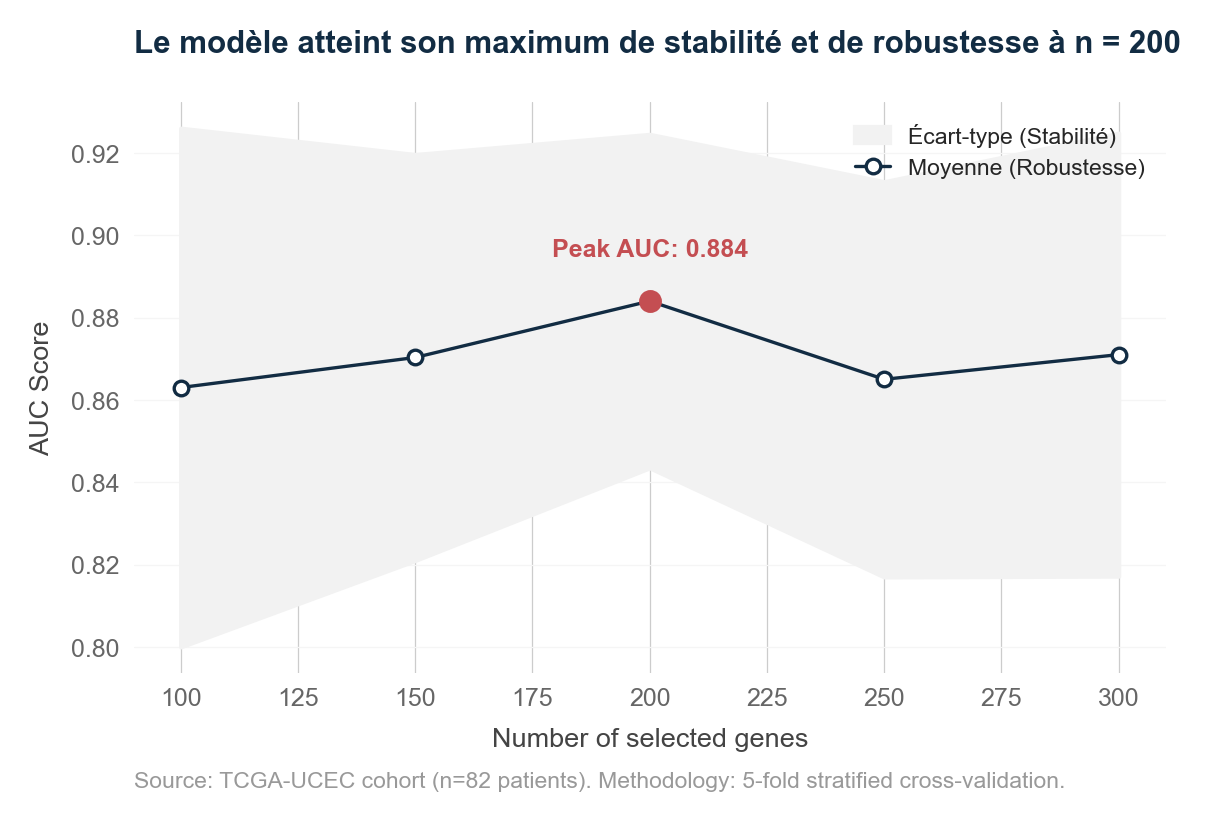

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Configuration "Executive & Fine"
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica'],
    'font.size': 7,
    'axes.linewidth': 0,
    'grid.linewidth': 0.3,
})

# Données
n_genes = np.array([100, 150, 200, 250, 300])
mean_auc = np.array([0.8630, 0.8703, 0.8840, 0.8650, 0.8710])
std_auc = np.array([0.0630, 0.0493, 0.0405, 0.0480, 0.0538])
optimal_idx = 2

# Palette
color_main = '#122C43'      # Deep Navy
color_accent = '#C44E52'    # Rouge académique (plus fin que le bleu clair pour l'optimum)
color_fill = '#F2F2F2'      # Gris très clair

fig, ax = plt.subplots(figsize=(4, 2.8), dpi=300)

# 1. Aire d'écart-type (Stabilité)
ax.fill_between(n_genes, mean_auc - std_auc, mean_auc + std_auc, 
                color=color_fill, zorder=1, label='Écart-type (Stabilité)')

# 2. Ligne de performance (Robustesse) - Trait fin et points cerclés
ax.plot(n_genes, mean_auc, color=color_main, marker='o', 
        markersize=3.5, markerfacecolor='white', markeredgewidth=0.8,
        linewidth=0.8, zorder=3, label='Moyenne (Robustesse)')

# 3. Point Optimum (Marqueur distinct)
ax.plot(n_genes[optimal_idx], mean_auc[optimal_idx], 'o', 
        markersize=4.5, color=color_accent, zorder=4)

# 4. Grille et axes épurés
ax.yaxis.grid(True, linestyle='-', color='#F5F5F5', zorder=0)
ax.set_xlabel('Number of selected genes', fontsize=6.5, color='#444444')
ax.set_ylabel('AUC Score', fontsize=6.5, color='#444444')
ax.tick_params(axis='both', which='major', labelsize=6, colors='#666666', length=0)

# 5. Titre réduit et explicite
ax.set_title('Le modèle atteint son maximum de stabilité et de robustesse à n = 200', 
             loc='left', fontsize=7.5, color=color_main, pad=12, fontweight='bold')

# 6. Légende clarifiée (Haut Droite)
# On utilise la légende automatique qui va reprendre les styles de lignes/surfaces
ax.legend(loc='upper right', fontsize=5.5, frameon=False, handlelength=1.5)

# 7. Annotation fine de l'optimum
ax.text(200, 0.895, f'Peak AUC: {mean_auc[optimal_idx]:.3f}', 
        color=color_accent, fontsize=6, fontweight='bold', ha='center')

# 8. Note de bas de page (Source complète)
source_text = "Source: TCGA-UCEC cohort (n=82 patients). Methodology: 5-fold stratified cross-validation."
ax.text(0, -0.2, source_text, transform=ax.transAxes, fontsize=5.5, color='#999999')

plt.tight_layout()

# Sauvegarde
output_path = "Fig_UCEC_Optimization_McKinsey_Nature_Hybrid.png"
plt.savefig(output_path, dpi=600, facecolor='white', bbox_inches='tight')
plt.show()

## 5.2. Filtrage statistique (Mann-Whitney)

<small>**Action - Sélection top 200 gènes Mann-Whitney**</small>

In [27]:
from scipy.stats import mannwhitneyu
import pandas as pd
import numpy as np

n_top_genes = 200

print("=" * 80)
print("5.2 : FILTRAGE STATISTIQUE (MANN-WHITNEY)")
print("=" * 80)

n_genes_initial = df_expr_supervised.shape[1]
print(f"\n📊 Gènes initiaux : {n_genes_initial}")

pvalues = []
gene_names = []

for gene in df_expr_supervised.columns:
    group_0 = df_expr_supervised.loc[y_supervised == 0, gene]
    group_1 = df_expr_supervised.loc[y_supervised == 1, gene]
    
    stat, pval = mannwhitneyu(group_0, group_1, alternative='two-sided')
    pvalues.append(pval)
    gene_names.append(gene)

df_pvalues = pd.DataFrame({
    'gene': gene_names,
    'pvalue': pvalues
}).sort_values('pvalue')

top_genes = df_pvalues.head(n_top_genes)['gene'].tolist()
df_expr_filtered = df_expr_supervised[top_genes].copy()

print(f"\n✅ Sélection terminée :")
print(f"  • Gènes conservés : {len(top_genes)}")
print(f"  • P-value minimale : {df_pvalues['pvalue'].min():.2e}")
print(f"  • P-value médiane (top {n_top_genes}) : {df_pvalues.head(n_top_genes)['pvalue'].median():.2e}")
print(f"  • P-value maximale (top {n_top_genes}) : {df_pvalues.head(n_top_genes)['pvalue'].max():.2e}")

df_pvalues.to_csv(f"{DIRS['FEATURES']}/5_2_mannwhitney_pvalues.csv", index=False)
df_expr_filtered.to_csv(f"{DIRS['PROCESSED']}/tmp_expr_n82_top{n_top_genes}.csv.gz", compression='gzip')

print(f"\n✅ ÉTAPE 5.2 - ACTION TERMINÉE")
print(f"Variables : df_expr_filtered {df_expr_filtered.shape} | df_pvalues {df_pvalues.shape}")

5.2 : FILTRAGE STATISTIQUE (MANN-WHITNEY)

📊 Gènes initiaux : 21168

✅ Sélection terminée :
  • Gènes conservés : 200
  • P-value minimale : 8.87e-06
  • P-value médiane (top 200) : 4.50e-04
  • P-value maximale (top 200) : 1.11e-03

✅ ÉTAPE 5.2 - ACTION TERMINÉE
Variables : df_expr_filtered (82, 200) | df_pvalues (21168, 2)


<small>**Visualisation 1 - Histogramme des p-values**</small>

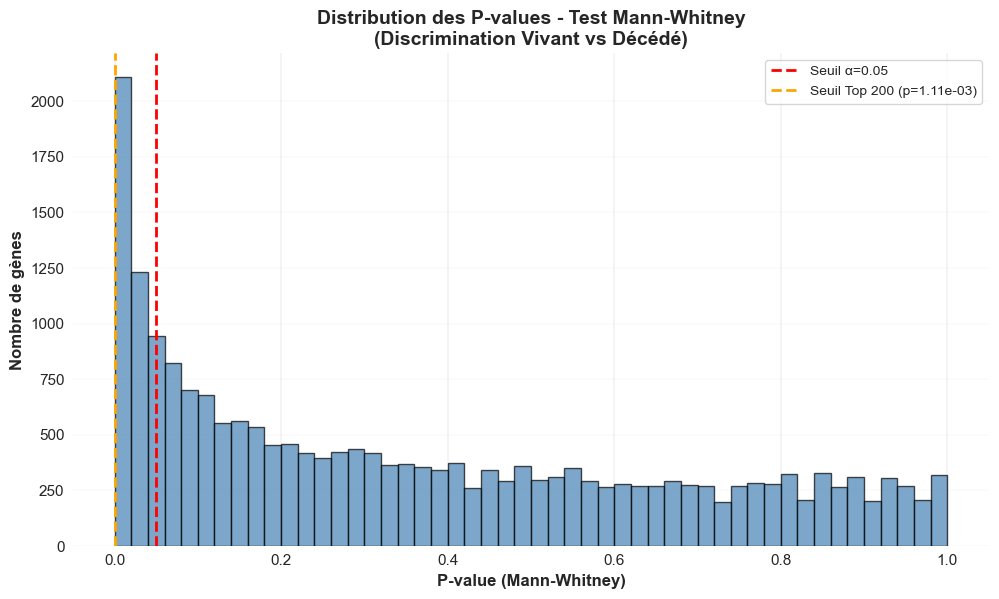

💾 Figure : c:\Z\M2_AIDA\TCGA_UCEC_project\data\artefacts\feature_selection/5_2_pvalue_histogram.png


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

n_top_genes = 200

fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(df_pvalues['pvalue'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(0.05, color='red', linestyle='--', linewidth=2, label='Seuil α=0.05')
ax.axvline(df_pvalues.head(n_top_genes)['pvalue'].max(), color='orange', linestyle='--', 
           linewidth=2, label=f'Seuil Top {n_top_genes} (p={df_pvalues.head(n_top_genes)["pvalue"].max():.2e})')
ax.set_xlabel('P-value (Mann-Whitney)', fontsize=12, weight='bold')
ax.set_ylabel('Nombre de gènes', fontsize=12, weight='bold')
ax.set_title('Distribution des P-values - Test Mann-Whitney\n(Discrimination Vivant vs Décédé)', 
             fontsize=14, weight='bold')
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f"{DIRS['FEATURES']}/5_2_pvalue_histogram.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"💾 Figure : {DIRS['FEATURES']}/5_2_pvalue_histogram.png")

<small>**Visualisation 2 - Heatmap signature (Top 50)**</small>

✅ Heatmap sauvegardée : c:\Z\M2_AIDA\TCGA_UCEC_project\data\processed\heatmap_top50_clustering.png


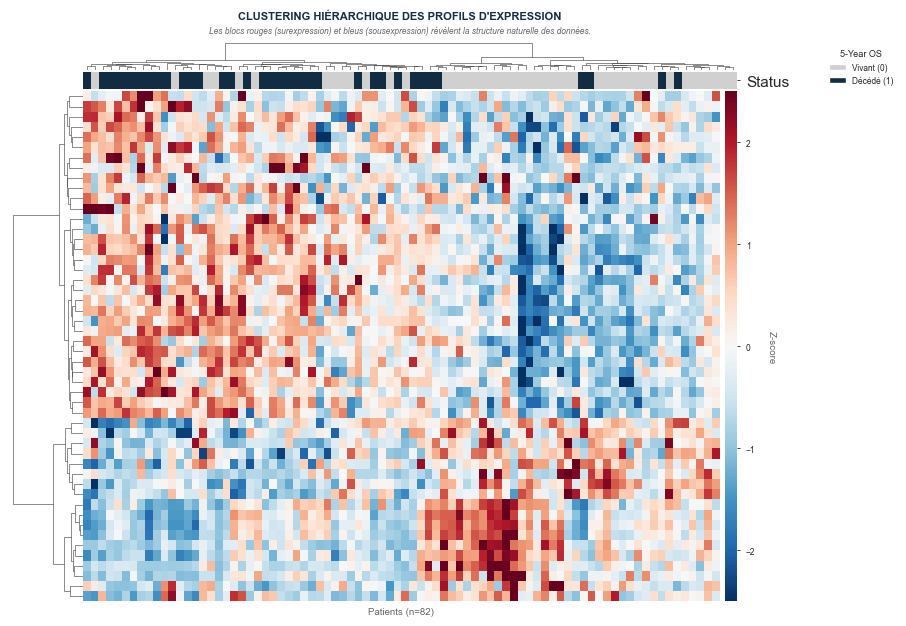

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os

# 1. Préparation (Top 50 gènes)
top_genes = df_pvalues.head(50)['gene'].tolist()
df_plot = df_expr_supervised[top_genes].T

# Standardisation par gène (Z-score)
df_plot_scaled = df_plot.apply(lambda x: (x - x.mean()) / x.std(), axis=1)

# 2. Palette de couleurs "Executive"
lut = {0: "#D0D0D0", 1: "#122C43"} 
col_colors = y_supervised.map(lut)
col_colors.name = "Status"

# 3. Création de la Clustermap SANS colorbar
g = sns.clustermap(
    df_plot_scaled,
    cmap='RdBu_r', 
    center=0,
    vmin=-2.5, vmax=2.5,
    col_colors=col_colors,
    metric='euclidean',
    method='ward',
    figsize=(8, 6),
    dendrogram_ratio=(0.1, 0.05),
    cbar_pos=None,
    xticklabels=False,
    yticklabels=False,
    tree_kws={'linewidths': 0.4}
)

# 4. Créer manuellement la colorbar à droite de la heatmap
divider = make_axes_locatable(g.ax_heatmap)
cax = divider.append_axes("right", size="2%", pad=0.05)
cbar = plt.colorbar(g.ax_heatmap.collections[0], cax=cax)
cbar.set_label('Z-score', rotation=270, labelpad=15, fontsize=7, color='#666666')
cbar.ax.tick_params(labelsize=6)

# 5. Nettoyage et labels
g.ax_heatmap.set_xlabel(f'Patients (n={len(y_supervised)})', fontsize=7, color='#666666')
g.ax_heatmap.set_ylabel('')

# 6. Titres centrés et décalés vers le haut
g.fig.text(0.5, 0.99, 'CLUSTERING HIÉRARCHIQUE DES PROFILS D\'EXPRESSION',
           fontsize=8, fontweight='bold', color='#122C43', ha='center')
g.fig.text(0.5, 0.965, 'Les blocs rouges (surexpression) et bleus (sousexpression) révèlent la structure naturelle des données.',
           fontsize=6, color='#666666', ha='center', style='italic')

# 7. Légende Status
legend_elements = [Patch(facecolor='#D0D0D0', label='Vivant (0)'),
                   Patch(facecolor='#122C43', label='Décédé (1)')]
g.ax_col_dendrogram.legend(handles=legend_elements, title="5-Year OS", 
                           loc='upper right', bbox_to_anchor=(1.25, 1.0), 
                           frameon=False, fontsize=6, title_fontsize=6.5)

plt.subplots_adjust(top=0.95)

# 8. SAUVEGARDE (PNG haute résolution - meilleur que JPG sans perte)
output_path = os.path.join(DIRS['PROCESSED'], 'heatmap_top50_clustering.png')
plt.savefig(output_path, dpi=600, bbox_inches='tight')

print(f"✅ Heatmap sauvegardée : {output_path}")

plt.show()

## 5.2.b Filtrage redondance (élimination redondance)

<small>**Action - Élimination gènes corrélés (ρ > 0.85)**</small>

In [60]:
from scipy.stats import spearmanr
from scipy.cluster.hierarchy import linkage, fcluster
import pandas as pd
import numpy as np

print("=" * 80)
print("5.2b : FILTRAGE REDONDANCE (CORRÉLATION)")
print("=" * 80)

n_genes_before = df_expr_filtered.shape[1]
print(f"\n📊 Gènes avant filtrage : {n_genes_before}")

corr_matrix = df_expr_filtered.corr(method='spearman').abs()

upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

high_corr_pairs = []
for col in upper_triangle.columns:
    correlated_genes = upper_triangle.index[upper_triangle[col] > 0.85].tolist()
    for gene in correlated_genes:
        high_corr_pairs.append((col, gene, upper_triangle.loc[gene, col]))

print(f"\n🔍 Paires de gènes corrélés (|ρ| > 0.85) : {len(high_corr_pairs)}")

genes_to_remove = set()
for gene1, gene2, corr_val in high_corr_pairs:
    if gene1 not in genes_to_remove and gene2 not in genes_to_remove:
        pval1 = df_pvalues[df_pvalues['gene'] == gene1]['pvalue'].values[0]
        pval2 = df_pvalues[df_pvalues['gene'] == gene2]['pvalue'].values[0]
        
        if pval1 > pval2:
            genes_to_remove.add(gene1)
        else:
            genes_to_remove.add(gene2)

genes_kept = [g for g in df_expr_filtered.columns if g not in genes_to_remove]
df_expr_decorrelated = df_expr_filtered[genes_kept].copy()

n_genes_after = df_expr_decorrelated.shape[0]
n_genes_removed = n_genes_before - len(genes_kept)

print(f"\n✅ Filtrage terminé :")
print(f"  • Gènes éliminés : {n_genes_removed}")
print(f"  • Gènes conservés : {len(genes_kept)}")
print(f"  • Ratio p/n final : {len(genes_kept)}/{df_expr_decorrelated.shape[0]} = {len(genes_kept)/df_expr_decorrelated.shape[0]:.2f}")

df_expr_decorrelated.to_csv(f"{DIRS['PROCESSED']}/tmp_expr_n82_decorrelated.csv.gz", compression='gzip')

redundant_genes_df = pd.DataFrame({
    'gene_removed': list(genes_to_remove),
    'reason': 'correlation > 0.85'
})
redundant_genes_df.to_csv(f"{DIRS['FEATURES']}/5_2b_redundant_genes.csv", index=False)

print(f"\n✅ ÉTAPE 5.2b - ACTION TERMINÉE")
print(f"Variables : df_expr_decorrelated {df_expr_decorrelated.shape}")

5.2b : FILTRAGE REDONDANCE (CORRÉLATION)

📊 Gènes avant filtrage : 200

🔍 Paires de gènes corrélés (|ρ| > 0.85) : 50

✅ Filtrage terminé :
  • Gènes éliminés : 11
  • Gènes conservés : 189
  • Ratio p/n final : 189/82 = 2.30

✅ ÉTAPE 5.2b - ACTION TERMINÉE
Variables : df_expr_decorrelated (82, 189)


## 5.3. Fusion multimodale (Modèle hybride : signal transcriptomique + clinique)

<small>**Action - Fusion (Gènes + Grade + FIGO One-Hot)**</small>

In [64]:
import pandas as pd
import numpy as np

print("=" * 80)
print("5.4 : FUSION MULTIMODALE (sans standardisation)")
print("=" * 80)

# Alignement des index
common_ids = df_expr_decorrelated.index.intersection(df_grade.index).intersection(df_figo_onehot.index)

df_expr_aligned = df_expr_decorrelated.loc[common_ids]
df_grade_aligned = df_grade.loc[common_ids]
df_figo_aligned = df_figo_onehot.loc[common_ids]
y_aligned = y_supervised.loc[common_ids]

print(f"\n📊 Alignement des modalités :")
print(f"  • Expression génique : {df_expr_aligned.shape}")
print(f"  • Grade tumoral : {df_grade_aligned.shape}")
print(f"  • FIGO (One-Hot) : {df_figo_aligned.shape}")
print(f"  • Labels : {y_aligned.shape}")

# Fusion DIRECTE sans standardisation (changement ici !)
X_combined = pd.concat([df_expr_aligned, df_grade_aligned, df_figo_aligned], axis=1)

print(f"\n✅ Fusion terminée (NON standardisé) :")
print(f"  • Dimensions finales : {X_combined.shape}")
print(f"  • Composition : {df_expr_aligned.shape[1]} gènes + {df_grade_aligned.shape[1]} grade + {df_figo_aligned.shape[1]} FIGO")
print(f"  • Ratio features/samples : {X_combined.shape[1]}/{X_combined.shape[0]} = {X_combined.shape[1]/X_combined.shape[0]:.2f}")

# Vérification des échelles brutes
print(f"\n📊 Échelles avant standardisation :")
print(f"  • Gènes : min={df_expr_aligned.min().min():.2f}, max={df_expr_aligned.max().max():.2f}")
print(f"  • Grade : valeurs uniques = {sorted(df_grade_aligned.iloc[:, 0].unique())}")
print(f"  • FIGO : valeurs uniques = {sorted(df_figo_aligned.values.flatten().tolist())[:3]}")

# Vérifications
assert X_combined.isna().sum().sum() == 0, "❌ NaN détectés après fusion"
assert X_combined.index.equals(y_aligned.index), "❌ Index désalignés"

print(f"\n🔒 Vérifications : OK")

# Sauvegarde
X_combined.to_csv(f"{DIRS['ML_READY']}/X_multimodal_n82.csv.gz", compression='gzip')
y_aligned.to_csv(f"{DIRS['ML_READY']}/y_supervised_OS5.csv")

print(f"\n✅ ÉTAPE 5.4 - ACTION TERMINÉE")
print(f"Variables : X_combined {X_combined.shape} | y_aligned {y_aligned.shape}")
print("=" * 80)

5.4 : FUSION MULTIMODALE (sans standardisation)

📊 Alignement des modalités :
  • Expression génique : (82, 189)
  • Grade tumoral : (82, 1)
  • FIGO (One-Hot) : (82, 4)
  • Labels : (82,)

✅ Fusion terminée (NON standardisé) :
  • Dimensions finales : (82, 194)
  • Composition : 189 gènes + 1 grade + 4 FIGO
  • Ratio features/samples : 194/82 = 2.37

📊 Échelles avant standardisation :
  • Gènes : min=0.00, max=10.99
  • Grade : valeurs uniques = [1, 2, 3]
  • FIGO : valeurs uniques = [0.0, 0.0, 0.0]

🔒 Vérifications : OK

✅ ÉTAPE 5.4 - ACTION TERMINÉE
Variables : X_combined (82, 194) | y_aligned (82,)


<small>**Visualisation - Corrélation Grade vs Top 5 Gènes**</small>

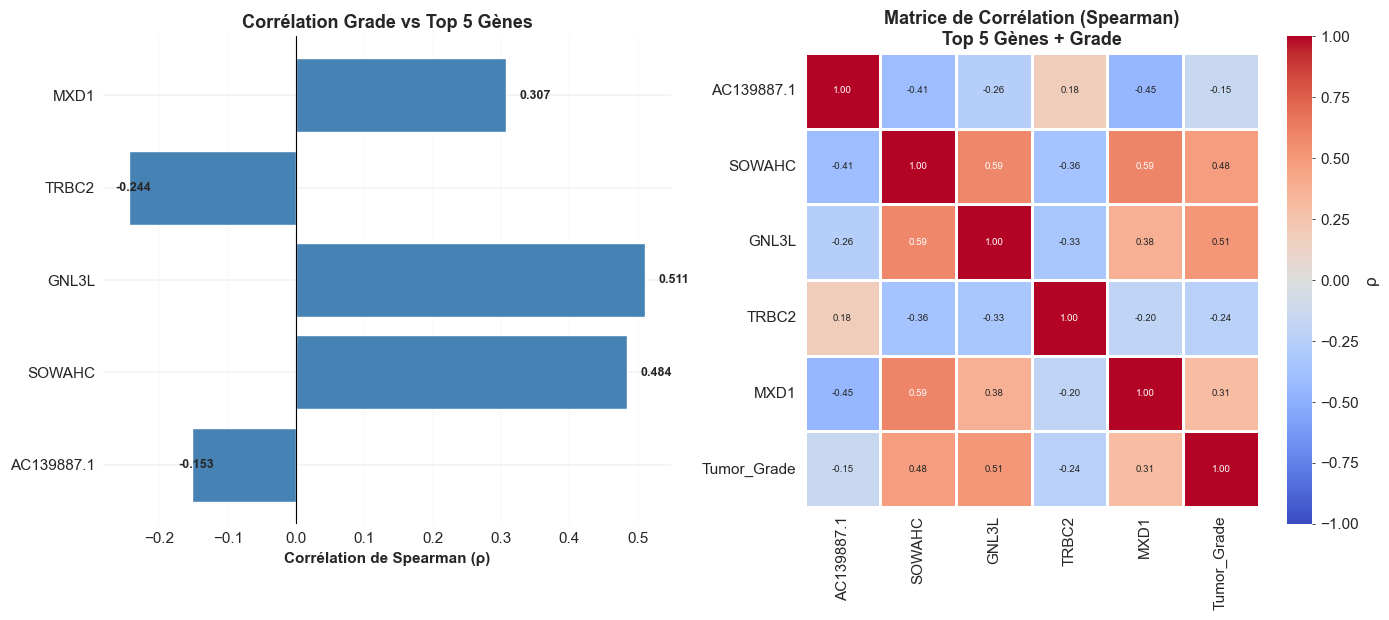

💾 Figure : c:\Z\M2_AIDA\TCGA_UCEC_project\data\artefacts\feature_selection/5_4_correlation_grade_genes.png
Corrélation entre grade tumoral et top 5 gènes discriminants. Les corrélations modérées (|ρ| < 0.6) 
      justifient l'approche multimodale.


In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

top_5_genes = df_pvalues.head(5)['gene'].tolist()

df_corr_analysis = pd.concat([
    df_expr_aligned[top_5_genes],
    df_grade_aligned
], axis=1)

corr_matrix = df_corr_analysis.corr(method='spearman')
grade_correlations = corr_matrix.loc[top_5_genes, df_grade_aligned.columns[0]]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].barh(range(len(grade_correlations)), grade_correlations.values, color='steelblue')
axes[0].set_yticks(range(len(grade_correlations)))
axes[0].set_yticklabels(grade_correlations.index)
axes[0].set_xlabel('Corrélation de Spearman (ρ)', fontsize=11, weight='bold')
axes[0].set_title('Corrélation Grade vs Top 5 Gènes', fontsize=13, weight='bold')
axes[0].axvline(0, color='black', linewidth=0.8)
axes[0].grid(axis='x', alpha=0.3)

for i, val in enumerate(grade_correlations.values):
    axes[0].text(val + 0.02 if val > 0 else val - 0.02, i, f'{val:.3f}', 
                va='center', fontsize=9, weight='bold')

sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={'label': 'ρ'}, ax=axes[1],
            vmin=-1, vmax=1)
axes[1].set_title('Matrice de Corrélation (Spearman)\nTop 5 Gènes + Grade', 
                 fontsize=13, weight='bold')

plt.tight_layout()
plt.savefig(f"{DIRS['FEATURES']}/5_4_correlation_grade_genes.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"💾 Figure : {DIRS['FEATURES']}/5_4_correlation_grade_genes.png")
print(f"Corrélation entre grade tumoral et top 5 gènes discriminants. Les corrélations modérées (|ρ| < 0.6) \n      justifient l'approche multimodale.")

## 5.5. Packaging & export ML-Ready (X_combined_multimodal + y_binary_OS5)

<small>**Action - Export final X_combined_multimodal**</small>

In [67]:
import pandas as pd
import numpy as np

print("=" * 80)
print("5.5 : PACKAGING & EXPORT FINAL")
print("=" * 80)

print(f"\n📊 Dimensions finales :")
print(f"  • X_combined_multimodal : {X_combined.shape}")
print(f"  • y_supervised_OS5 : {y_aligned.shape}")

y_recurrence = df_clin.loc[common_ids, 'paper_recurred_progressed'].copy()
y_recurrence_binary = y_recurrence.map({'No': 0, 'Yes': 1})

print(f"\n📋 Variable de validation (Récurrence) :")
print(f"  • Dimensions : {y_recurrence_binary.shape}")
print(f"  • Complétude : {y_recurrence_binary.notna().sum()}/{len(y_recurrence_binary)} ({y_recurrence_binary.notna().sum()/len(y_recurrence_binary)*100:.1f}%)")
print(f"  • Distribution : {y_recurrence_binary.value_counts().to_dict()}")

y_recurrence_binary.to_csv(f"{DIRS['ML_READY']}/y_validation_recurrence.csv")

metadata_export = pd.DataFrame({
    'dataset': ['X_combined_multimodal', 'y_supervised_OS5', 'y_validation_recurrence'],
    'n_samples': [X_combined.shape[0], y_aligned.shape[0], y_recurrence_binary.shape[0]],
    'n_features': [X_combined.shape[1], 1, 1],
    'composition': [
        f"{df_expr_aligned.shape[1]} gènes + {df_grade_scaled.shape[1]} grade + {df_figo_aligned.shape[1]} FIGO",
        "OS 5 ans (0=Vivant, 1=Décédé)",
        "Récurrence (0=Non, 1=Oui)"
    ],
    'filepath': [
        f"{DIRS['ML_READY']}/X_combined_multimodal.csv.gz",
        f"{DIRS['ML_READY']}/y_supervised_OS5.csv",
        f"{DIRS['ML_READY']}/y_validation_recurrence.csv"
    ]
})

metadata_export.to_csv(f"{DIRS['ML_READY']}/metadata_export_supervised.csv", index=False)

print(f"\n✅ Fichiers exportés :")
for _, row in metadata_export.iterrows():
    print(f"  • {row['dataset']} : {row['filepath']}")

print(f"\n✅ ÉTAPE 5.5 - ACTION TERMINÉE")
print(f"\n🎯 FLUX B (MLP SUPERVISÉ) COMPLÉTÉ")

5.5 : PACKAGING & EXPORT FINAL

📊 Dimensions finales :
  • X_combined_multimodal : (82, 194)
  • y_supervised_OS5 : (82,)

📋 Variable de validation (Récurrence) :
  • Dimensions : (82,)
  • Complétude : 77/82 (93.9%)
  • Distribution : {0.0: 42, 1.0: 35}

✅ Fichiers exportés :
  • X_combined_multimodal : c:\Z\M2_AIDA\TCGA_UCEC_project\data\processed\ml_ready/X_combined_multimodal.csv.gz
  • y_supervised_OS5 : c:\Z\M2_AIDA\TCGA_UCEC_project\data\processed\ml_ready/y_supervised_OS5.csv
  • y_validation_recurrence : c:\Z\M2_AIDA\TCGA_UCEC_project\data\processed\ml_ready/y_validation_recurrence.csv

✅ ÉTAPE 5.5 - ACTION TERMINÉE

🎯 FLUX B (MLP SUPERVISÉ) COMPLÉTÉ


<small>**Visualisation - Ratio p/n & Régularisations**</small>

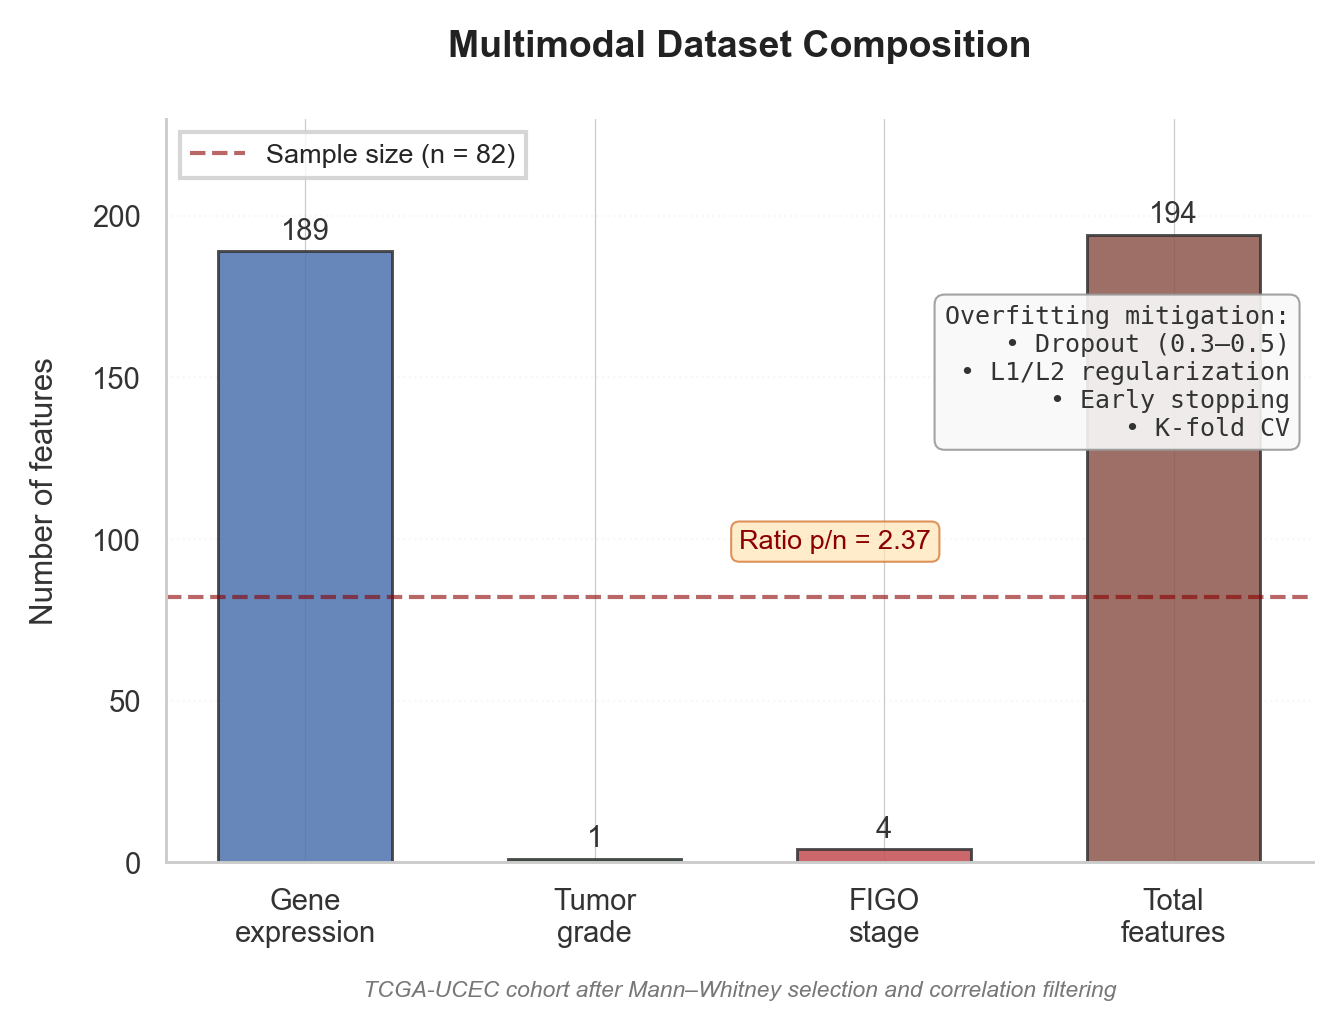

In [71]:
import matplotlib.pyplot as plt
import numpy as np

# Configuration style Nature/Science - Polices affinées
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
    'font.size': 7.5, # Légèrement réduit
    'axes.linewidth': 0.7,
    'xtick.major.width': 0.7,
    'ytick.major.width': 0.7,
})

n_samples = X_combined.shape[0]
n_features = X_combined.shape[1]
ratio_pn = n_features / n_samples

fig, ax = plt.subplots(figsize=(4.5, 3.5), dpi=300)

# Données
categories = ['Gene\nexpression', 'Tumor\ngrade', 'FIGO\nstage', 'Total\nfeatures']
values = [df_expr_aligned.shape[1], df_grade_aligned.shape[1], df_figo_aligned.shape[1], n_features]

colors = ['#4C72B0', '#55A868', '#C44E52', '#8C564B']

bars = ax.bar(categories, values, color=colors, edgecolor='#333333', 
              linewidth=0.7, alpha=0.85, width=0.6)

for bar, val in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 2,
            f'{val}', ha='center', va='bottom', fontsize=7, 
            color='#333333')

# Ligne de référence
ax.axhline(n_samples, color='#8B0000', linestyle='--', linewidth=1.0, 
            alpha=0.6, label=f'Sample size (n = {n_samples})')

# 1. CORRECTION CHEVAUCHEMENT : Annotation ratio remontée
ax.text(1.5, n_samples + 15, f'Ratio p/n = {ratio_pn:.2f}', 
        fontsize=6.5, weight='medium', color='#8B0000',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='#FFE4B5', 
                  edgecolor='#D2691E', linewidth=0.5, alpha=0.7))

ax.set_ylabel('Number of features', fontsize=7.5, labelpad=8, color='#333333')
ax.set_ylim(0, 230) # Augmenté pour laisser de la place en haut
ax.set_title('Multimodal Dataset Composition',
             fontsize=9, weight='bold', pad=15, color='#222222')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', labelsize=7, colors='#333333')
ax.grid(axis='y', alpha=0.15, linestyle=':', linewidth=0.5)

ax.legend(fontsize=6.5, frameon=True, fancybox=False, 
          edgecolor='#CCCCCC', framealpha=0.8, loc='upper left')

# 2. CORRECTION CHEVAUCHEMENT : Encadré overfitting remonté (0.75 au lieu de 0.65)
textstr = 'Overfitting mitigation:\n• Dropout (0.3–0.5)\n• L1/L2 regularization\n• Early stopping\n• K-fold CV'

props = dict(boxstyle='round,pad=0.4', facecolor='#F9F9F9', 
             edgecolor='#999999', linewidth=0.5, alpha=0.9)
ax.text(0.98, 0.75, textstr, transform=ax.transAxes, fontsize=6,
        verticalalignment='top', horizontalalignment='right', 
        bbox=props, color='#333333', family='monospace')

# 3. CORRECTION CHEVAUCHEMENT : Note de bas de page abaissée (-0.18 au lieu de -0.12)
ax.text(0.5, -0.18, 'TCGA-UCEC cohort after Mann–Whitney selection and correlation filtering',
        transform=ax.transAxes, fontsize=5.5, style='italic', 
        color='#777777', ha='center') # Centré pour plus d'équilibre

plt.tight_layout()
plt.savefig(f"{DIRS['FEATURES']}/Fig_multimodal_composition_Nature_v2.png", 
            dpi=600, bbox_inches='tight')
plt.show()

---
# 6. Preprocessing Autoencodeur "Unsupervised"

## 6.1. Extension de la cohorte ($n=553$)

<small>**Action - Chargement cohorte complète (n=553)**</small>

In [72]:
import pandas as pd
import numpy as np

print("=" * 80)
print("6.1 : EXTENSION DE LA COHORTE (n=553)")
print("=" * 80)

df_expr_full = df_expr.copy()

print(f"\n📊 Cohorte complète :")
print(f"  • Patientes : {df_expr_full.shape[0]}")
print(f"  • Gènes : {df_expr_full.shape[1]}")

print(f"\n📋 Informations cliniques disponibles :")
histology_col = 'disease_type' if 'disease_type' in df_clin.columns else 'paper_histological_type'
if histology_col in df_clin.columns:
    histology_counts = df_clin[histology_col].value_counts()
    print(f"  • Types histologiques ({histology_col}) :")
    for histo_type, count in histology_counts.items():
        print(f"    - {histo_type}: {count} ({count/len(df_clin)*100:.1f}%)")
else:
    print(f"  • Colonne histologie non trouvée")

assert df_expr_full.index.equals(df_clin.index), "❌ Index désalignés"
assert df_expr_full.isna().sum().sum() == 0, "❌ NaN détectés"

print(f"\n🔒 Vérifications : OK")

df_expr_full.to_csv(f"{DIRS['PROCESSED']}/tmp_expr_n553_full.csv.gz", compression='gzip')

print(f"\n✅ ÉTAPE 6.1 - ACTION TERMINÉE")
print(f"Variables : df_expr_full {df_expr_full.shape}")

6.1 : EXTENSION DE LA COHORTE (n=553)

📊 Cohorte complète :
  • Patientes : 553
  • Gènes : 21168

📋 Informations cliniques disponibles :
  • Types histologiques (disease_type) :

🔒 Vérifications : OK

✅ ÉTAPE 6.1 - ACTION TERMINÉE
Variables : df_expr_full (553, 21168)


<small>**Visualisation - Densité histologique**</small>

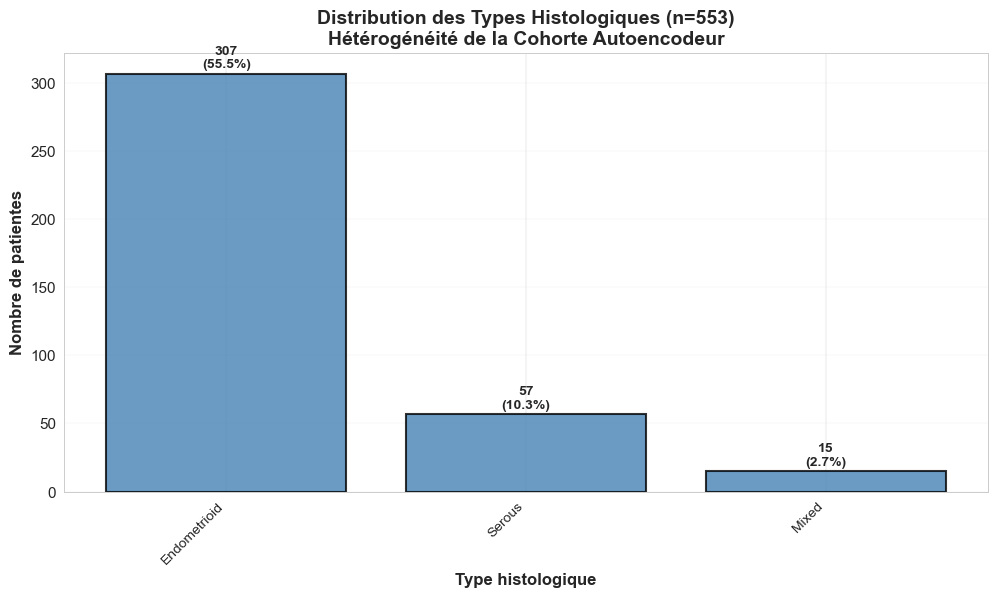

In [76]:
histology_col = 'paper_histology'

if histology_col in df_clin.columns:
    histology_data = df_clin[histology_col].dropna().value_counts()  # ← Ajoute dropna()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    bars = ax.bar(range(len(histology_data)), histology_data.values, 
                  color='steelblue', edgecolor='black', linewidth=1.5, alpha=0.8)
    
    ax.set_xticks(range(len(histology_data)))
    ax.set_xticklabels(histology_data.index, rotation=45, ha='right', fontsize=10)
    ax.set_ylabel('Nombre de patientes', fontsize=12, weight='bold')
    ax.set_xlabel('Type histologique', fontsize=12, weight='bold')
    ax.set_title(f'Distribution des Types Histologiques (n={df_expr_full.shape[0]})\nHétérogénéité de la Cohorte Autoencodeur',
                 fontsize=14, weight='bold')
    
    for i, (bar, val) in enumerate(zip(bars, histology_data.values)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 2,
                f'{val}\n({val/df_expr_full.shape[0]*100:.1f}%)',
                ha='center', va='bottom', fontsize=10, weight='bold')
    
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"{DIRS['FEATURES']}/6_1_histology_distribution.png", dpi=300, bbox_inches='tight')
    plt.show()

## 6.2. Filtrage par haute variance (Sélection "à l'aveugle")

<small>**Validation - Test comparatif 512/1024/2048/4096 gènes (MSE reconstruction)**
<br>Pour chaque taille (512, 1024, 2048, 4096), benchmark empirique :
<br>- Sélection des N gènes les plus variables
<br>- Entraînement d'un mini-autoencodeur (10 epochs)
<br>- Comparaison des MSE de reconstruction
</small>

TEST : SÉLECTION OPTIMALE DU NOMBRE DE GÈNES HAUTE VARIANCE

🧪 Test avec 512 gènes...
  ✓ Train MSE : 3.070158
  ✓ Val MSE   : 3.155261

🧪 Test avec 1024 gènes...
  ✓ Train MSE : 2.388730
  ✓ Val MSE   : 2.509448

🧪 Test avec 2048 gènes...
  ✓ Train MSE : 2.090172
  ✓ Val MSE   : 2.154774

🧪 Test avec 4096 gènes...
  ✓ Train MSE : 1.774481
  ✓ Val MSE   : 1.781892


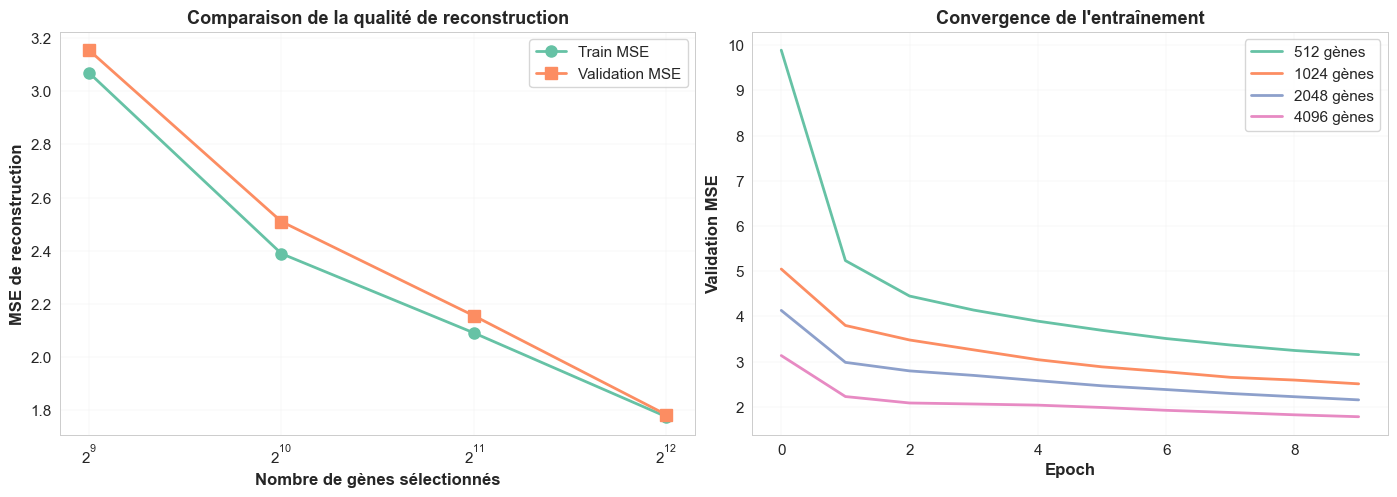


📊 RÉSULTATS FINAUX
    512 gènes : Val MSE = 3.155261
   1024 gènes : Val MSE = 2.509448
   2048 gènes : Val MSE = 2.154774
🏆 4096 gènes : Val MSE = 1.781892

✅ RECOMMANDATION : 4096 gènes (MSE validation minimal)


In [78]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# ============================================================================
# TEST DE DIFFÉRENTES TAILLES DE FEATURES
# ============================================================================

n_features_list = [512, 1024, 2048, 4096]
results = {}

print("="*80)
print("TEST : SÉLECTION OPTIMALE DU NOMBRE DE GÈNES HAUTE VARIANCE")
print("="*80)

for n_features in n_features_list:
    print(f"\n🧪 Test avec {n_features} gènes...")
    
    # Sélection des top N gènes par variance
    variances = df_expr_full.var(axis=0)
    top_genes = variances.nlargest(n_features).index
    X_subset = df_expr_full[top_genes].values
    
    # Split train/val
    X_train, X_val = train_test_split(X_subset, test_size=0.2, random_state=42)
    
    # Architecture simple pour test rapide
    latent_dim = min(128, n_features // 8)  # Adaptatif
    
    input_layer = Input(shape=(n_features,))
    encoded = Dense(latent_dim, activation='relu')(input_layer)
    decoded = Dense(n_features, activation='linear')(encoded)
    
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer=Adam(0.001), loss='mse')
    
    # Entraînement rapide (10 epochs suffisent pour comparer)
    history = autoencoder.fit(
        X_train, X_train,
        validation_data=(X_val, X_val),
        epochs=10,
        batch_size=32,
        verbose=0
    )
    
    # Stockage des résultats
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    
    results[n_features] = {
        'train_mse': final_train_loss,
        'val_mse': final_val_loss,
        'history': history.history
    }
    
    print(f"  ✓ Train MSE : {final_train_loss:.6f}")
    print(f"  ✓ Val MSE   : {final_val_loss:.6f}")

# ============================================================================
# VISUALISATION
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graphique 1 : MSE finale
n_feat = list(results.keys())
train_mse = [results[n]['train_mse'] for n in n_feat]
val_mse = [results[n]['val_mse'] for n in n_feat]

axes[0].plot(n_feat, train_mse, 'o-', label='Train MSE', linewidth=2, markersize=8)
axes[0].plot(n_feat, val_mse, 's-', label='Validation MSE', linewidth=2, markersize=8)
axes[0].set_xlabel('Nombre de gènes sélectionnés', fontsize=12, weight='bold')
axes[0].set_ylabel('MSE de reconstruction', fontsize=12, weight='bold')
axes[0].set_title('Comparaison de la qualité de reconstruction', fontsize=13, weight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)
axes[0].set_xscale('log', base=2)

# Graphique 2 : Courbes d'apprentissage pour chaque config
for n_features in n_features_list:
    history = results[n_features]['history']
    axes[1].plot(history['val_loss'], label=f'{n_features} gènes', linewidth=2)

axes[1].set_xlabel('Epoch', fontsize=12, weight='bold')
axes[1].set_ylabel('Validation MSE', fontsize=12, weight='bold')
axes[1].set_title('Convergence de l\'entraînement', fontsize=13, weight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f"{DIRS['FEATURES']}/6_2_feature_selection_test.png", dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# RECOMMANDATION
# ============================================================================

best_n = min(results.keys(), key=lambda x: results[x]['val_mse'])

print("\n" + "="*80)
print("📊 RÉSULTATS FINAUX")
print("="*80)
for n_features in n_features_list:
    marker = "🏆" if n_features == best_n else "  "
    print(f"{marker} {n_features:4d} gènes : Val MSE = {results[n_features]['val_mse']:.6f}")

print(f"\n✅ RECOMMANDATION : {best_n} gènes (MSE validation minimal)")
print("="*80)

<small>**Action - Filtrage variance : top 4096 gènes (sélection optimisée via test de reconstruction)**</small>

In [79]:
# ============================================================================
# 6.2 : FILTRAGE PAR HAUTE VARIANCE (TOP 4096)
# ============================================================================

N_TOP_GENES_AE = 4096  # Sélectionné via test de reconstruction (Val MSE=1.78)

print("="*80)
print(f"6.2 : FILTRAGE PAR HAUTE VARIANCE (TOP {N_TOP_GENES_AE})")
print("="*80)

variances = df_expr_full.var(axis=0)
top_genes = variances.nlargest(N_TOP_GENES_AE).index

df_expr_highvar = df_expr_full[top_genes].copy()

print(f"📊 Gènes initiaux : {df_expr_full.shape[1]}")
print(f"✅ Sélection terminée :")
print(f"  • Gènes conservés : {N_TOP_GENES_AE}")
print(f"  • Variance minimale (top {N_TOP_GENES_AE}) : {variances[top_genes].min():.4f}")
print(f"  • Variance médiane (top {N_TOP_GENES_AE}) : {variances[top_genes].median():.4f}")
print(f"  • Variance maximale (top {N_TOP_GENES_AE}) : {variances[top_genes].max():.4f}")

print(f"✅ ÉTAPE 6.2 - ACTION TERMINÉE")
print(f"Variables : df_expr_highvar ({df_expr_highvar.shape[0]}, {df_expr_highvar.shape[1]})")

6.2 : FILTRAGE PAR HAUTE VARIANCE (TOP 4096)
📊 Gènes initiaux : 21168
✅ Sélection terminée :
  • Gènes conservés : 4096
  • Variance minimale (top 4096) : 1.1048
  • Variance médiane (top 4096) : 1.7224
  • Variance maximale (top 4096) : 13.3608
✅ ÉTAPE 6.2 - ACTION TERMINÉE
Variables : df_expr_highvar (553, 4096)


<small>**Visualisation 1 - Variance Plot (ligne de coupure)**</small>

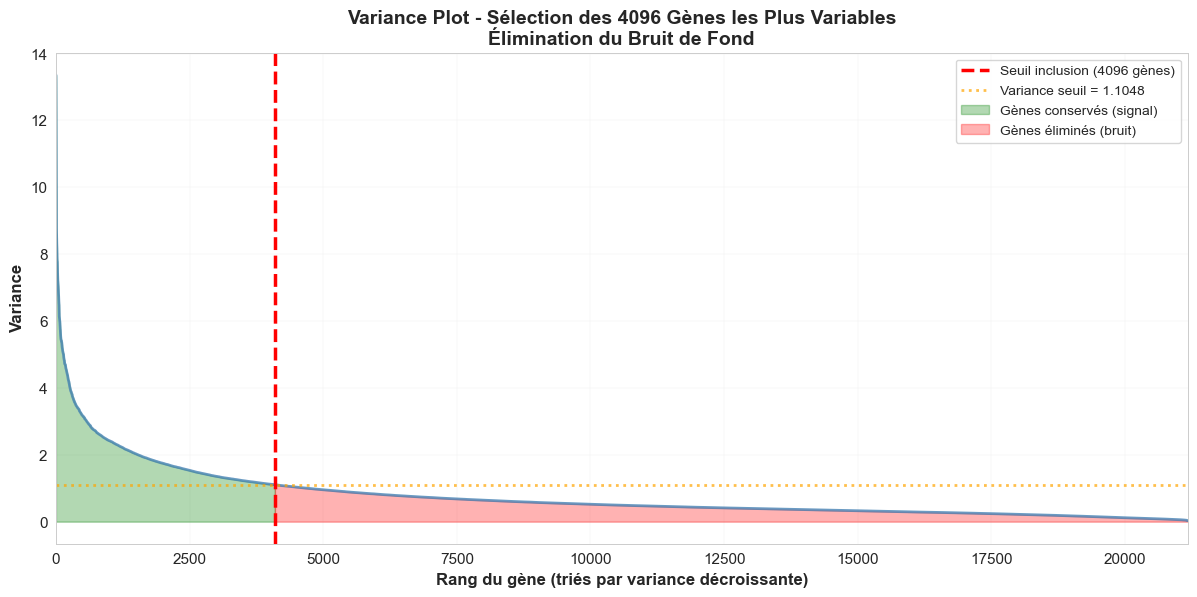

💾 Figure : c:\Z\M2_AIDA\TCGA_UCEC_project\data\artefacts\feature_selection/6_2_variance_plot.png


In [81]:
import matplotlib.pyplot as plt
import numpy as np

N_TOP_GENES_AE = 4096

fig, ax = plt.subplots(figsize=(12, 6))

sorted_variances = df_variance_stats['variance'].values
gene_ranks = np.arange(1, len(sorted_variances) + 1)

ax.plot(gene_ranks, sorted_variances, color='steelblue', linewidth=2, alpha=0.8)
ax.axvline(N_TOP_GENES_AE, color='red', linestyle='--', linewidth=2.5, 
           label=f'Seuil inclusion ({N_TOP_GENES_AE} gènes)')
ax.axhline(df_variance_stats.iloc[N_TOP_GENES_AE-1]['variance'], color='orange', 
           linestyle=':', linewidth=2, alpha=0.7,
           label=f'Variance seuil = {df_variance_stats.iloc[N_TOP_GENES_AE-1]["variance"]:.4f}')

ax.fill_between(gene_ranks[:N_TOP_GENES_AE], 0, sorted_variances[:N_TOP_GENES_AE], 
                alpha=0.3, color='green', label='Gènes conservés (signal)')
ax.fill_between(gene_ranks[N_TOP_GENES_AE:], 0, sorted_variances[N_TOP_GENES_AE:], 
                alpha=0.3, color='red', label='Gènes éliminés (bruit)')

ax.set_xlabel('Rang du gène (triés par variance décroissante)', fontsize=12, weight='bold')
ax.set_ylabel('Variance', fontsize=12, weight='bold')
ax.set_title(f'Variance Plot - Sélection des {N_TOP_GENES_AE} Gènes les Plus Variables\nÉlimination du Bruit de Fond',
             fontsize=14, weight='bold')
ax.set_xlim(0, len(sorted_variances))
ax.legend(fontsize=10, loc='upper right')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f"{DIRS['FEATURES']}/6_2_variance_plot.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"💾 Figure : {DIRS['FEATURES']}/6_2_variance_plot.png")

<small>**Visualisation 2 - Scree Plot (distribution)**</small>

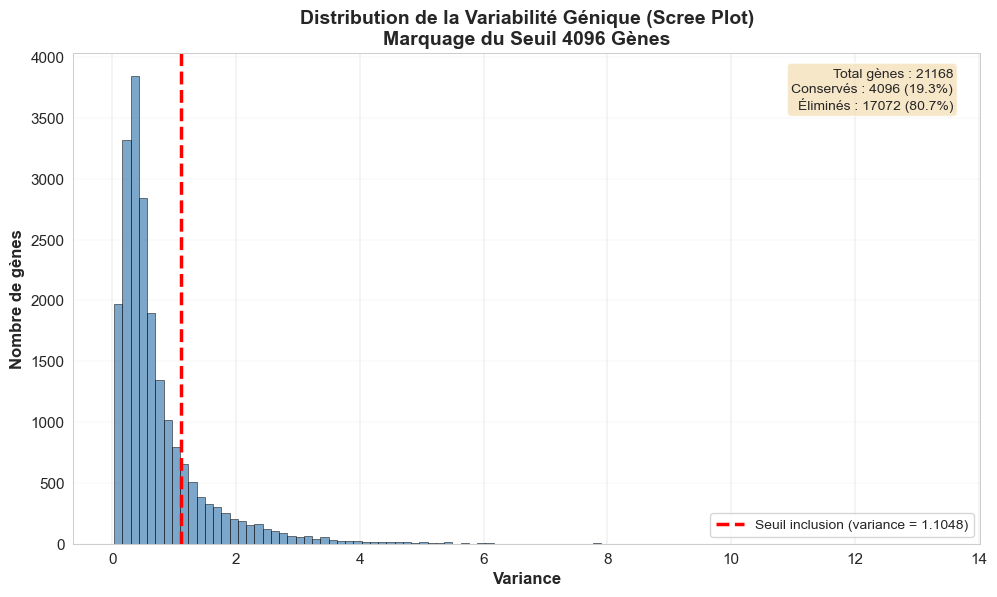

💾 Figure : c:\Z\M2_AIDA\TCGA_UCEC_project\data\artefacts\feature_selection/6_2_scree_plot.png


In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

N_TOP_GENES_AE = 4096

fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(df_variance_stats['variance'], bins=100, color='steelblue', 
        edgecolor='black', alpha=0.7, linewidth=0.5)

threshold_var = df_variance_stats.iloc[N_TOP_GENES_AE-1]['variance']
ax.axvline(threshold_var, color='red', linestyle='--', linewidth=2.5,
           label=f'Seuil inclusion (variance = {threshold_var:.4f})')

ax.set_xlabel('Variance', fontsize=12, weight='bold')
ax.set_ylabel('Nombre de gènes', fontsize=12, weight='bold')
ax.set_title(f'Distribution de la Variabilité Génique (Scree Plot)\nMarquage du Seuil {N_TOP_GENES_AE} Gènes',
             fontsize=14, weight='bold')
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)

textstr = '\n'.join([
    f'Total gènes : {n_genes_initial}',
    f'Conservés : {N_TOP_GENES_AE} ({N_TOP_GENES_AE/n_genes_initial*100:.1f}%)',
    f'Éliminés : {n_genes_initial-N_TOP_GENES_AE} ({(n_genes_initial-N_TOP_GENES_AE)/n_genes_initial*100:.1f}%)'
])
props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
ax.text(0.97, 0.97, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right', bbox=props)

plt.tight_layout()
plt.savefig(f"{DIRS['FEATURES']}/6_2_scree_plot.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"💾 Figure : {DIRS['FEATURES']}/6_2_scree_plot.png")

## 6.3. Normalisation spécifique (Z-score)

<small>**Action 1 - Normalisation Z-score**</small>

In [84]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

print("=" * 80)
print("6.3 : NORMALISATION (Z-SCORE)")
print("=" * 80)

print(f"\n📊 Dimensions avant normalisation : {df_expr_highvar.shape}")

scaler = StandardScaler()
expr_scaled = scaler.fit_transform(df_expr_highvar)

df_expr_scaled_unsupervised = pd.DataFrame(
    expr_scaled,
    index=df_expr_highvar.index,
    columns=df_expr_highvar.columns
)

print(f"\n✅ Normalisation terminée")
print(f"  • Moyenne (vérification) : {df_expr_scaled_unsupervised.mean().mean():.2e}")
print(f"  • Écart-type (vérification) : {df_expr_scaled_unsupervised.std().mean():.2f}")

df_expr_scaled_unsupervised.to_csv(f"{DIRS['PROCESSED']}/tmp_expr_n553_scaled.csv.gz", compression='gzip')

print(f"\n✅ ÉTAPE 6.3 - ACTION TERMINÉE")
print(f"Variables : df_expr_scaled_unsupervised {df_expr_scaled_unsupervised.shape}")

6.3 : NORMALISATION (Z-SCORE)

📊 Dimensions avant normalisation : (553, 4096)

✅ Normalisation terminée
  • Moyenne (vérification) : -2.43e-18
  • Écart-type (vérification) : 1.00

✅ ÉTAPE 6.3 - ACTION TERMINÉE
Variables : df_expr_scaled_unsupervised (553, 4096)


<small>**Action 2 - Sanity Check (NaNs + alignement)**</small>

In [86]:
print("=" * 80)
print("6.3 : SANITY CHECK (INTÉGRITÉ)")
print("=" * 80)

N_TOP_GENES_AE = 4096

n_nans = df_expr_scaled_unsupervised.isna().sum().sum()
print(f"\n🔍 Vérification NaNs : {n_nans}")

if n_nans > 0:
    print(f"❌ ATTENTION : {n_nans} valeurs NaN détectées")
    nan_genes = df_expr_scaled_unsupervised.columns[df_expr_scaled_unsupervised.isna().any()].tolist()
    print(f"  • Gènes concernés : {nan_genes[:10]}")
else:
    print(f"✅ Aucun NaN détecté")

assert df_expr_scaled_unsupervised.index.equals(df_expr_full.index), "❌ Index désalignés"
print(f"✅ Index parfaitement alignés avec df_expr_full")

assert df_expr_scaled_unsupervised.shape[0] == 553, "❌ Nombre d'échantillons incorrect"
assert df_expr_scaled_unsupervised.shape[1] ==  N_TOP_GENES_AE, "❌ Nombre de gènes incorrect"
print(f"✅ Dimensions validées : {df_expr_scaled_unsupervised.shape}")

print(f"\n🔒 Sanity Check : PASSED")

6.3 : SANITY CHECK (INTÉGRITÉ)

🔍 Vérification NaNs : 0
✅ Aucun NaN détecté
✅ Index parfaitement alignés avec df_expr_full
✅ Dimensions validées : (553, 4096)

🔒 Sanity Check : PASSED


<small>**Visualisation - Heatmap co-expression (Top 50)**</small>

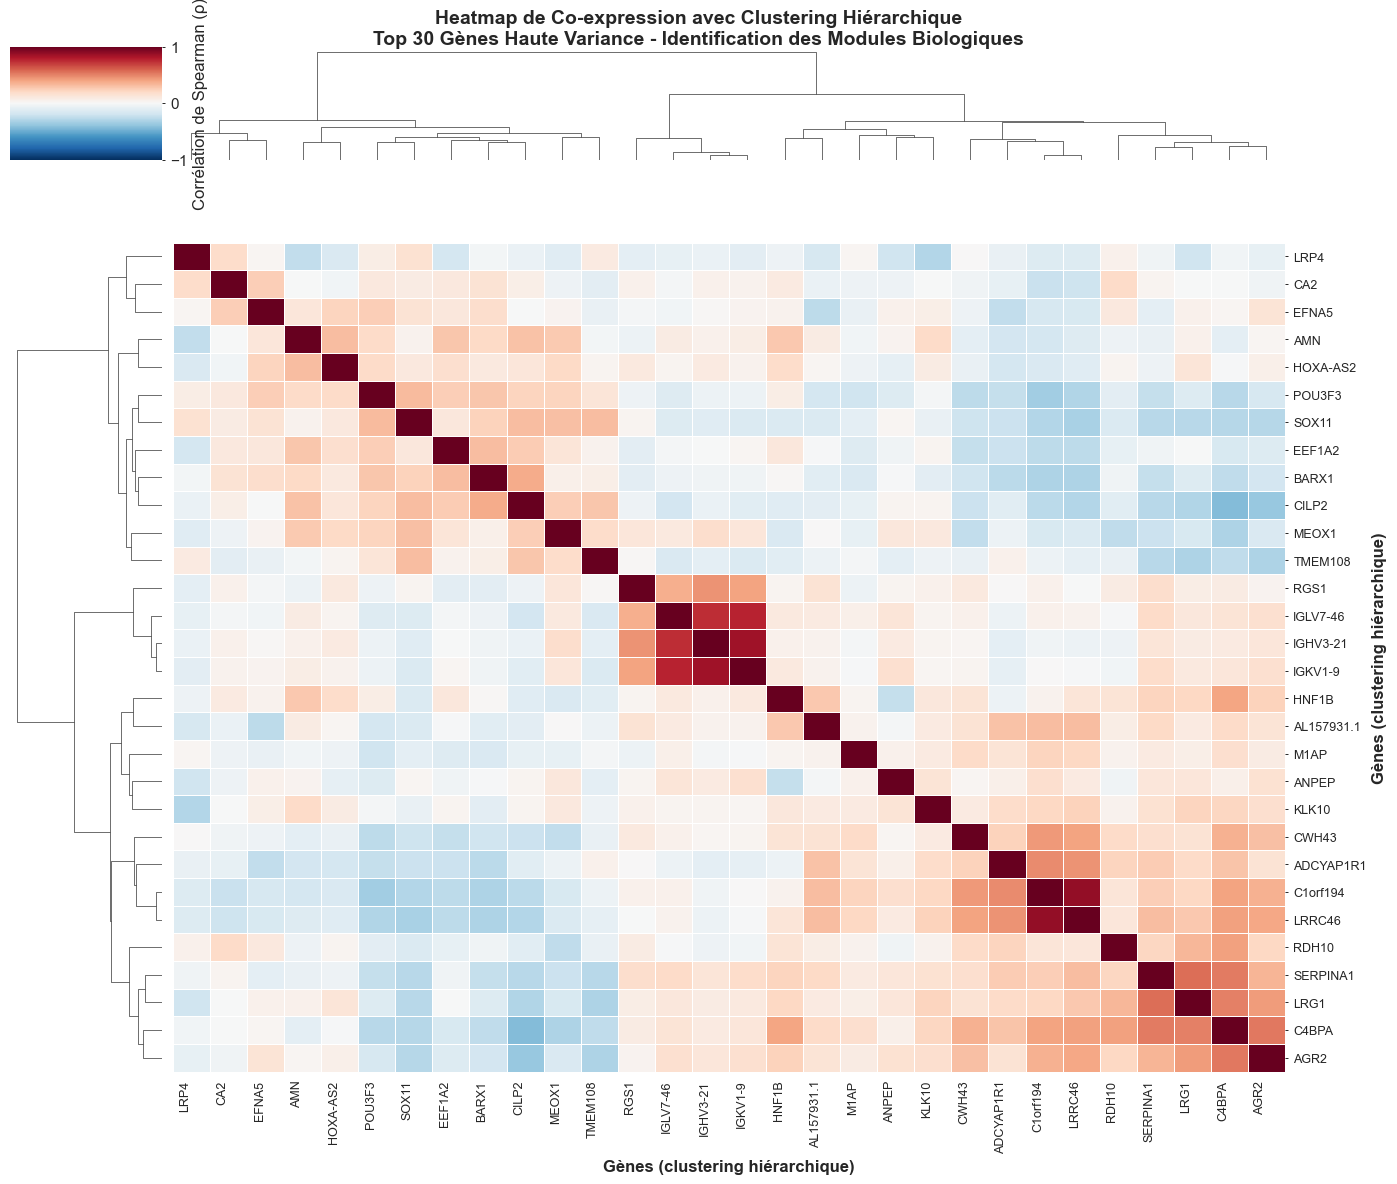

💾 Figure : c:\Z\M2_AIDA\TCGA_UCEC_project\data\artefacts\feature_selection/6_3_heatmap_clustered.png


In [89]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist

# Sélection des 30 gènes les plus variables (au lieu des 50 premiers)
top_genes_var = df_expr_scaled_unsupervised.var(axis=0).nlargest(30).index
df_top_unsup = df_expr_scaled_unsupervised[top_genes_var]

# Matrice de corrélation
corr_matrix_unsup = df_top_unsup.corr(method='spearman')

# Clustering hiérarchique (regroupe gènes similaires)
row_linkage = linkage(pdist(corr_matrix_unsup, metric='euclidean'), method='ward')
col_linkage = linkage(pdist(corr_matrix_unsup.T, metric='euclidean'), method='ward')

# Heatmap avec clustering automatique
g = sns.clustermap(
    corr_matrix_unsup,
    cmap='RdBu_r',
    center=0,
    vmin=-1, vmax=1,
    linewidths=0.5,
    cbar_kws={'label': 'Corrélation de Spearman (ρ)', 'shrink': 0.8},
    figsize=(14, 12),
    dendrogram_ratio=0.12,
    row_linkage=row_linkage,
    col_linkage=col_linkage,
    xticklabels=True,
    yticklabels=True,
    cbar_pos=(0.02, 0.83, 0.03, 0.15)
)

# Amélioration des labels
g.ax_heatmap.set_xlabel('Gènes (clustering hiérarchique)', fontsize=12, weight='bold')
g.ax_heatmap.set_ylabel('Gènes (clustering hiérarchique)', fontsize=12, weight='bold')
g.ax_heatmap.tick_params(axis='both', labelsize=9)

# Rotation des labels
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=90, ha='right')
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

# Titre
g.fig.suptitle(
    'Heatmap de Co-expression avec Clustering Hiérarchique\n'
    'Top 30 Gènes Haute Variance - Identification des Modules Biologiques',
    fontsize=14, weight='bold', y=0.98
)

plt.tight_layout()
plt.savefig(f"{DIRS['FEATURES']}/6_3_heatmap_clustered.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"💾 Figure : {DIRS['FEATURES']}/6_3_heatmap_clustered.png")

<small> **Interprétation** : La heatmap des 30 gènes les plus variables révèle une structure modulaire (blocs de co-expression) nette, confirmant que l'espace des gènes est hautement structuré et se prête à une compression non-linéaire via un espace latent (Bottleneck).
</small>

## 6.4. Diagnostic de structure (Baseline pré-compression)

<small>**Action 1 - Analyse structure naturelle**</small>

In [90]:
import pandas as pd
import numpy as np

print("=" * 80)
print("6.4 : DIAGNOSTIC DE STRUCTURE (BASELINE)")
print("=" * 80)

print(f"\n📊 Données pour analyse de structure :")
print(f"  • Expression : {df_expr_scaled_unsupervised.shape}")
print(f"  • Patientes : {df_expr_scaled_unsupervised.shape[0]}")
print(f"  • Gènes haute variance : {df_expr_scaled_unsupervised.shape[1]}")

print(f"\n✅ Données prêtes pour projections dimensionnelles")
print(f"Variables : df_expr_scaled_unsupervised {df_expr_scaled_unsupervised.shape}")

6.4 : DIAGNOSTIC DE STRUCTURE (BASELINE)

📊 Données pour analyse de structure :
  • Expression : (553, 4096)
  • Patientes : 553
  • Gènes haute variance : 4096

✅ Données prêtes pour projections dimensionnelles
Variables : df_expr_scaled_unsupervised (553, 4096)


<small>**Visualisation 1 - Projection UMAP (Histologie)**</small>

Calcul UMAP (peut prendre 1-2 minutes)...

🔍 Distribution histologique :
paper_histology
Endometrioid    307
Serous           57
Mixed            15
Name: count, dtype: int64


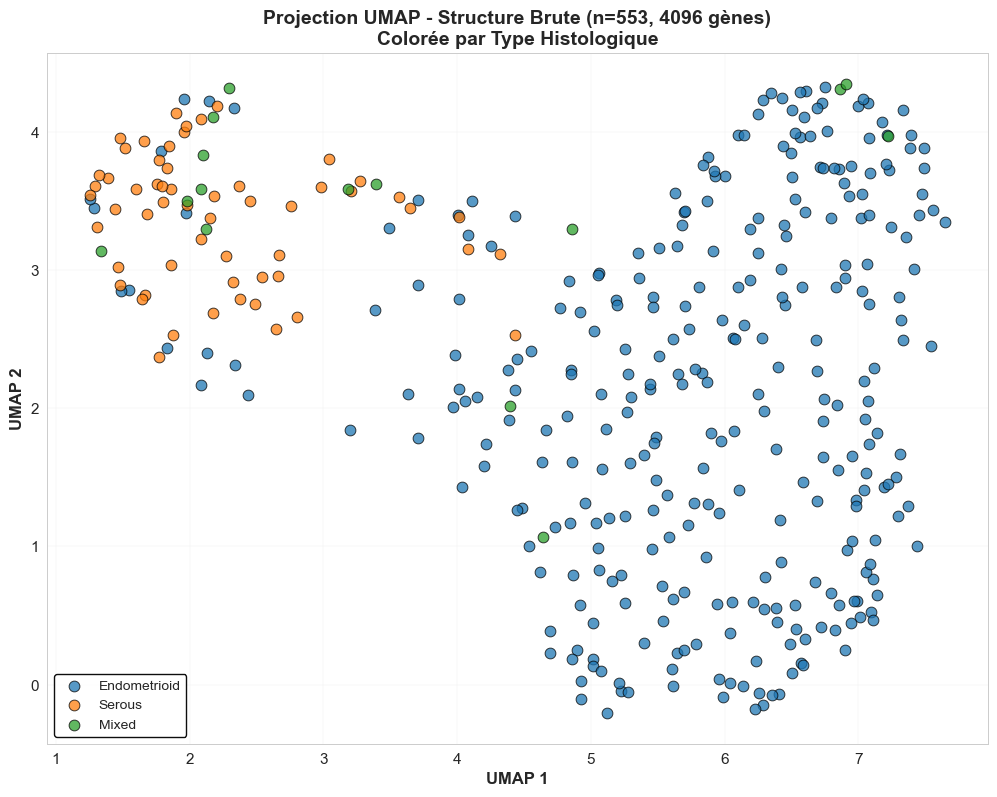

💾 Figure : c:\Z\M2_AIDA\TCGA_UCEC_project\data\artefacts\feature_selection/6_4_umap_histology.png


In [93]:
import matplotlib.pyplot as plt
import umap
import pandas as pd

print("Calcul UMAP (peut prendre 1-2 minutes)...")

reducer_umap = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding_umap = reducer_umap.fit_transform(df_expr_scaled_unsupervised)

histology_col = 'paper_histology'
histology_labels = df_clin.loc[df_expr_scaled_unsupervised.index, histology_col]

print(f"\n🔍 Distribution histologique :")
print(histology_labels.value_counts())

fig, ax = plt.subplots(figsize=(10, 8))

# PALETTE OPTIMISÉE AVEC CONTRASTE
color_map = {
    'Endometrioid': '#1f77b4',  # Bleu foncé
    'Serous': '#ff7f0e',         # Orange vif
    'Mixed': '#2ca02c'           # Vert foncé
}

for histo_type in histology_labels.dropna().unique():
    mask = histology_labels == histo_type
    ax.scatter(embedding_umap[mask, 0], embedding_umap[mask, 1], 
              c=color_map[histo_type], label=histo_type, 
              s=60, alpha=0.75, edgecolors='black', linewidth=0.7)

ax.set_xlabel('UMAP 1', fontsize=12, weight='bold')
ax.set_ylabel('UMAP 2', fontsize=12, weight='bold')
ax.set_title('Projection UMAP - Structure Brute (n=553, 4096 gènes)\nColorée par Type Histologique',
             fontsize=14, weight='bold')
ax.legend(fontsize=10, loc='best', framealpha=0.95, edgecolor='black')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f"{DIRS['FEATURES']}/6_4_umap_histology.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"💾 Figure : {DIRS['FEATURES']}/6_4_umap_histology.png")

<small>**Interprétation** : L'UMAP révèle une structure en gradient reflétant la diversité histologique de la cohorte UCEC. Cette baseline pré-compression valide la présence d'un signal biologique organisé et servira de référence pour évaluer la capacité de l'autoencodeur à préserver cette hétérogénéité moléculaire dans l'espace latent (Bottleneck).</small>

<small>**Visualisation 2 - Triptyque (PCA vs UMAP vs t-SNE)**</small>

Calcul des projections (peut prendre 2-3 minutes)...


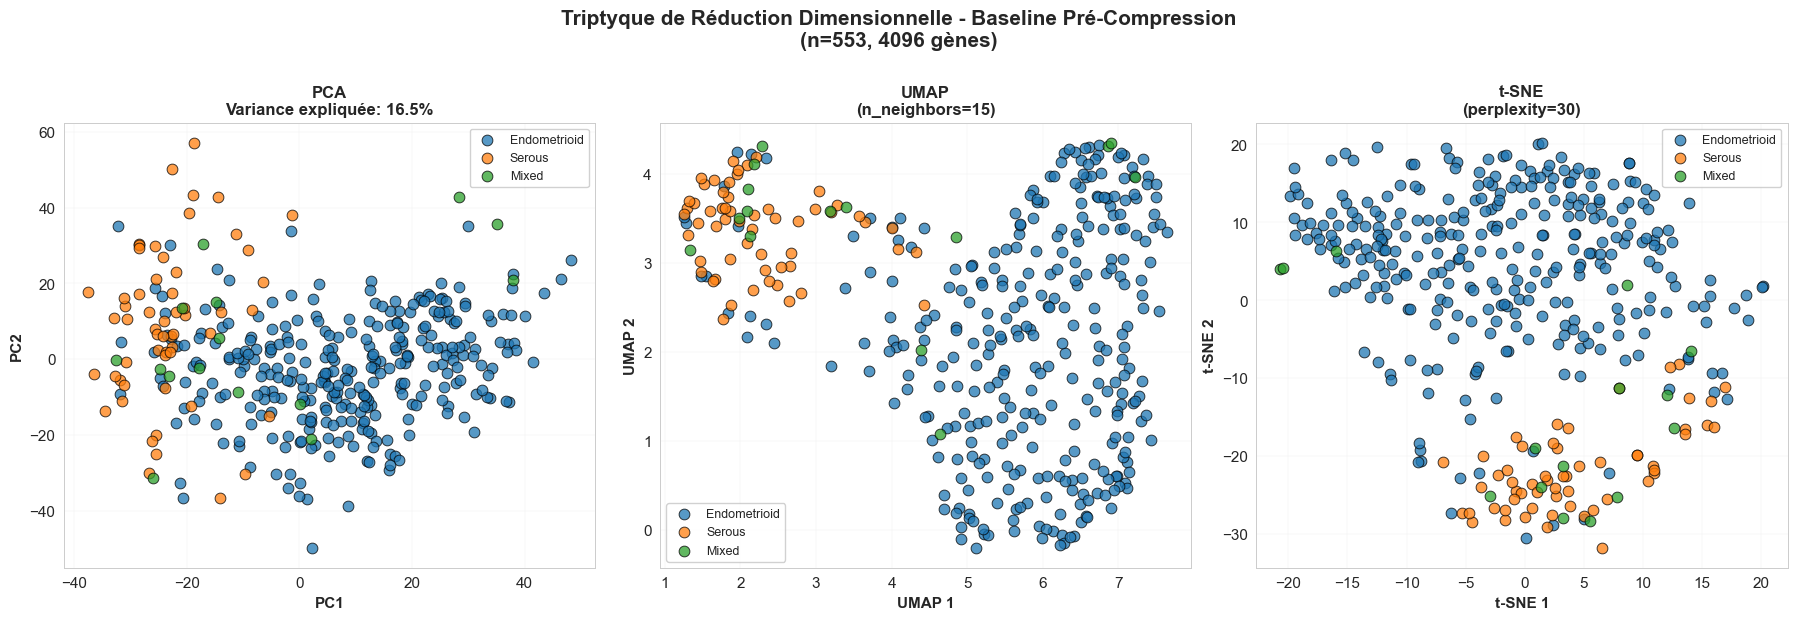

💾 Figure : c:\Z\M2_AIDA\TCGA_UCEC_project\data\artefacts\feature_selection/6_4_triptych_pca_umap_tsne.png


In [95]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

print("Calcul des projections (peut prendre 2-3 minutes)...")

pca = PCA(n_components=2, random_state=42)
embedding_pca = pca.fit_transform(df_expr_scaled_unsupervised)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embedding_tsne = tsne.fit_transform(df_expr_scaled_unsupervised)

reducer_umap_full = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding_umap_full = reducer_umap_full.fit_transform(df_expr_scaled_unsupervised)

# CORRECTION ICI
histology_col = 'paper_histology'
histology_labels = df_clin.loc[df_expr_scaled_unsupervised.index, histology_col]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# PALETTE CONTRASTÉE
color_map = {
    'Endometrioid': '#1f77b4',
    'Serous': '#ff7f0e',
    'Mixed': '#2ca02c'
}

for histo_type in histology_labels.dropna().unique():
    mask = histology_labels == histo_type
    
    axes[0].scatter(embedding_pca[mask, 0], embedding_pca[mask, 1],
                   c=color_map[histo_type], label=histo_type, s=60, alpha=0.75, edgecolors='black', linewidth=0.7)
    axes[1].scatter(embedding_umap_full[mask, 0], embedding_umap_full[mask, 1],
                   c=color_map[histo_type], label=histo_type, s=60, alpha=0.75, edgecolors='black', linewidth=0.7)
    axes[2].scatter(embedding_tsne[mask, 0], embedding_tsne[mask, 1],
                   c=color_map[histo_type], label=histo_type, s=60, alpha=0.75, edgecolors='black', linewidth=0.7)

axes[0].set_title(f'PCA\nVariance expliquée: {pca.explained_variance_ratio_.sum()*100:.1f}%',
                 fontsize=12, weight='bold')
axes[0].set_xlabel('PC1', fontsize=11, weight='bold')
axes[0].set_ylabel('PC2', fontsize=11, weight='bold')
axes[0].legend(fontsize=9, loc='best', framealpha=0.9)
axes[0].grid(alpha=0.3)

axes[1].set_title('UMAP\n(n_neighbors=15)', fontsize=12, weight='bold')
axes[1].set_xlabel('UMAP 1', fontsize=11, weight='bold')
axes[1].set_ylabel('UMAP 2', fontsize=11, weight='bold')
axes[1].legend(fontsize=9, loc='best', framealpha=0.9)
axes[1].grid(alpha=0.3)

axes[2].set_title('t-SNE\n(perplexity=30)', fontsize=12, weight='bold')
axes[2].set_xlabel('t-SNE 1', fontsize=11, weight='bold')
axes[2].set_ylabel('t-SNE 2', fontsize=11, weight='bold')
axes[2].legend(fontsize=9, loc='best', framealpha=0.9)
axes[2].grid(alpha=0.3)

fig.suptitle('Triptyque de Réduction Dimensionnelle - Baseline Pré-Compression\n(n=553, 4096 gènes)',  # ← Corrige "1024" en "4096"
            fontsize=15, weight='bold', y=1.02)

plt.tight_layout()
plt.savefig(f"{DIRS['FEATURES']}/6_4_triptych_pca_umap_tsne.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"💾 Figure : {DIRS['FEATURES']}/6_4_triptych_pca_umap_tsne.png")

<small>**Interprétation** : Le triptyque de réduction de dimension révèle une structure intrinsèque non-linéaire au sein des 4096 gènes. Alors que la PCA peine à isoler des groupes distincts, l'UMAP et le t-SNE mettent en évidence un gradient histologique continu. Cette baseline confirme que l'information est organisée et que l'espace latent de l'autoencodeur devra capturer ces relations complexes pour fournir des features pertinentes au futur classifieur.</small>

## 6.5. Packaging et export "Unsupervised" (X_for_autoencoder)

<small>**Action - Export final X_for_autoencoder et y_validation_recurrence**</small>

In [100]:
# ============================================================================
# 6.5 : PACKAGING & EXPORT FINAL (AUTOENCODEUR)
# ============================================================================

import pandas as pd
import numpy as np

print("=" * 80)
print("6.5 : PACKAGING & EXPORT FINAL (AUTOENCODEUR)")
print("=" * 80)

# ============================================================================
# EXPORT X
# ============================================================================
print(f"\n📊 Dimensions finales :")
print(f"  • X_for_autoencoder : {df_expr_scaled_unsupervised.shape}")
print(f"  • Composition : {df_expr_scaled_unsupervised.shape[0]} patientes × {df_expr_scaled_unsupervised.shape[1]} gènes (Z-score)")

df_expr_scaled_unsupervised.to_csv(f"{DIRS['ML_READY']}/X_for_autoencoder.csv.gz", compression='gzip')
print(f"\n✅ Fichier exporté : {DIRS['ML_READY']}/X_for_autoencoder.csv.gz")

# ============================================================================
# EXPORT Y (RÉCURRENCE)
# ============================================================================
y_recurrence_full = df_clin.loc[df_expr_scaled_unsupervised.index, 'paper_recurred_progressed'].copy()

# Mapping correct avec gestion des NaN
y_recurrence_full_binary = y_recurrence_full.map({
    'No': 0, 
    'Yes': 1
    # 'Unknown' reste NaN (non mappé)
})

print(f"\n📋 Variable de validation (Récurrence) :")
print(f"  • Dimensions : {y_recurrence_full_binary.shape}")
print(f"  • Complétude : {y_recurrence_full_binary.notna().sum()}/{len(y_recurrence_full_binary)} ({y_recurrence_full_binary.notna().sum()/len(y_recurrence_full_binary)*100:.1f}%)")
print(f"  • Distribution : {y_recurrence_full_binary.value_counts(dropna=False).to_dict()}")

y_recurrence_full_binary.to_csv(f"{DIRS['ML_READY']}/y_validation_recurrence_full.csv")
print(f"\n💾 Export : {DIRS['ML_READY']}/y_validation_recurrence_full.csv")
print(f"✅ Cette variable servira à valider la cohérence biologique de l'espace latent")

# ============================================================================
# MÉTADONNÉES
# ============================================================================
metadata_export_unsupervised = pd.DataFrame({
    'dataset': ['X_for_autoencoder', 'y_validation_recurrence_full'],
    'n_samples': [df_expr_scaled_unsupervised.shape[0], y_recurrence_full_binary.shape[0]],
    'n_features': [df_expr_scaled_unsupervised.shape[1], 1],
    'composition': [
        f"{df_expr_scaled_unsupervised.shape[1]} gènes haute variance (Z-score)",
        f"Récurrence (0=Non, 1=Oui) - {y_recurrence_full_binary.notna().sum()} valides"
    ],
    'filepath': [
        f"{DIRS['ML_READY']}/X_for_autoencoder.csv.gz",
        f"{DIRS['ML_READY']}/y_validation_recurrence_full.csv"
    ]
})

metadata_export_unsupervised.to_csv(f"{DIRS['ML_READY']}/metadata_export_unsupervised.csv", index=False)
print(f"\n✅ Métadonnées : {DIRS['ML_READY']}/metadata_export_unsupervised.csv")

print(f"\n✅ ÉTAPE 6.5 - ACTION TERMINÉE")
print(f"\n🎯 FLUX (AUTOENCODEUR) COMPLÉTÉ")

6.5 : PACKAGING & EXPORT FINAL (AUTOENCODEUR)

📊 Dimensions finales :
  • X_for_autoencoder : (553, 4096)
  • Composition : 553 patientes × 4096 gènes (Z-score)

✅ Fichier exporté : c:\Z\M2_AIDA\TCGA_UCEC_project\data\processed\ml_ready/X_for_autoencoder.csv.gz

📋 Variable de validation (Récurrence) :
  • Dimensions : (553,)
  • Complétude : 357/553 (64.6%)
  • Distribution : {0.0: 285, nan: 196, 1.0: 72}

💾 Export : c:\Z\M2_AIDA\TCGA_UCEC_project\data\processed\ml_ready/y_validation_recurrence_full.csv
✅ Cette variable servira à valider la cohérence biologique de l'espace latent

✅ Métadonnées : c:\Z\M2_AIDA\TCGA_UCEC_project\data\processed\ml_ready/metadata_export_unsupervised.csv

✅ ÉTAPE 6.5 - ACTION TERMINÉE

🎯 FLUX (AUTOENCODEUR) COMPLÉTÉ


# 7. Summary

<small>**Tableau récapitulatif preprocessing Superevised vs Unsuperevised**</small>

GÉNÉRATION TABLEAU COMPARATIF : FLUX A (AUTOENCODEUR) vs FLUX B (MLP)


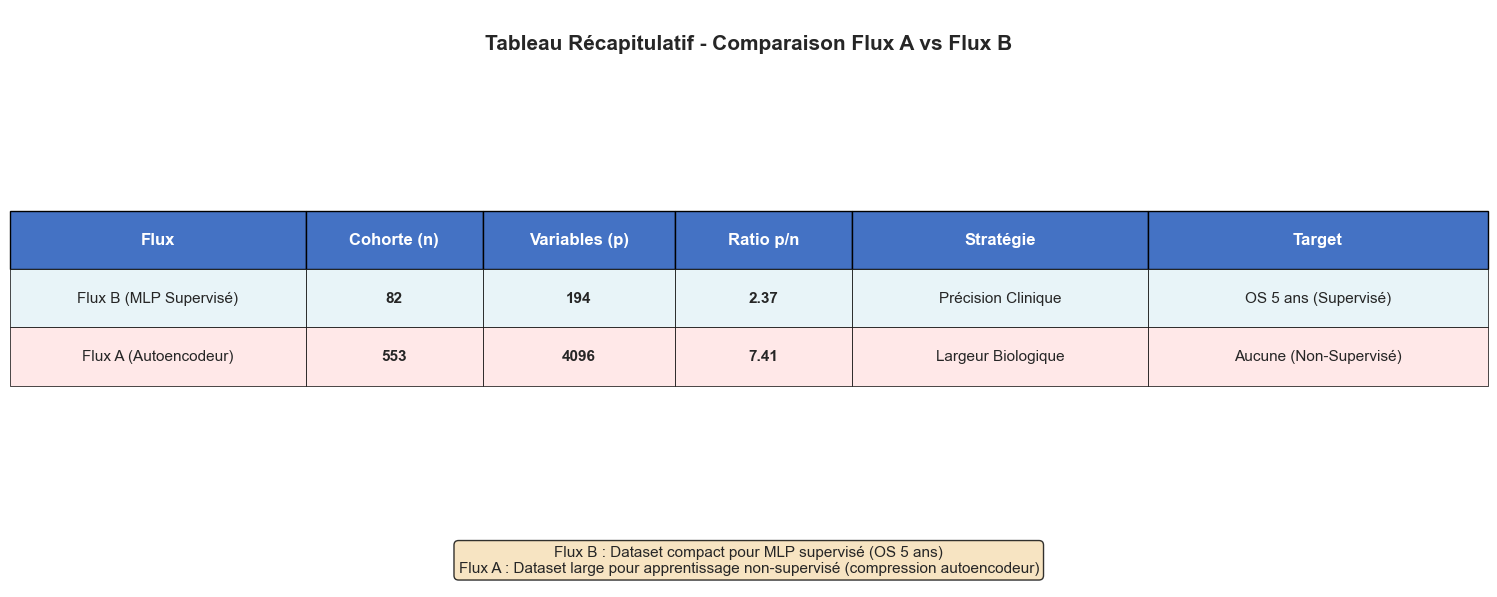


💾 Figure sauvegardée : c:\Z\M2_AIDA\TCGA_UCEC_project\data\artefacts\feature_selection/6_5_comparison_table.png

🎉 PREPROCESSING COMPLET (FLUX A + FLUX B)

📦 Fichiers ML-Ready disponibles :

  📊 Flux B (Supervisé - MLP) :
     • X : X_combined_multimodal.csv.gz (82 patients × 194 features)
     • y : y_supervised_OS5.csv (OS 5 ans)

  🧬 Flux A (Non-Supervisé - Autoencodeur) :
     • X : X_for_autoencoder.csv.gz (553 patients × 4096 gènes)
     • y : y_validation_recurrence_full.csv (validation post-hoc)

📈 Ratios p/n :
     • Flux B : 2.37 (précision avec risque overfitting contrôlé)
     • Flux A : 7.41 (richesse biologique maximale)

✅ Prêt pour l'étape suivante :
     • Script 0D : Entraînement MLP (Flux B)
     • Script 0E : Entraînement Autoencodeur (Flux A)


In [105]:
import matplotlib.pyplot as plt
import pandas as pd

# ============================================================================
# TABLEAU COMPARATIF FLUX A vs FLUX B
# ============================================================================

print("="*80)
print("GÉNÉRATION TABLEAU COMPARATIF : FLUX A (AUTOENCODEUR) vs FLUX B (MLP)")
print("="*80)

# Données comparatives
comparison_data = pd.DataFrame({
    'Flux': ['Flux B (MLP Supervisé)', 'Flux A (Autoencodeur)'],
    'Cohorte (n)': [82, 553],  # Valeurs fixes validées
    'Variables (p)': [194, 4096],  # Valeurs fixes validées
    'Ratio p/n': [
        f"{194/82:.2f}",
        f"{4096/553:.2f}"
    ],
    'Stratégie': ['Précision Clinique', 'Largeur Biologique'],
    'Target': ['OS 5 ans (Supervisé)', 'Aucune (Non-Supervisé)']
})

# Création de la figure
fig, ax = plt.subplots(figsize=(15, 6))
ax.axis('off')

# Création du tableau
table = ax.table(
    cellText=comparison_data.values,
    colLabels=comparison_data.columns,
    cellLoc='center',
    loc='center',
    colWidths=[0.20, 0.12, 0.13, 0.12, 0.20, 0.23]
)

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.8)

# Style de l'en-tête
for i in range(len(comparison_data.columns)):
    cell = table[(0, i)]
    cell.set_facecolor('#4472C4')
    cell.set_text_props(weight='bold', color='white', fontsize=12)

# Style des lignes (couleurs cohérentes avec les flux)
for i in range(1, len(comparison_data) + 1):
    # Flux B (MLP) en bleu clair
    if i == 1:
        color = '#E8F4F8'
    # Flux A (Autoencodeur) en rose clair
    else:
        color = '#FFE8E8'
    
    for j in range(len(comparison_data.columns)):
        cell = table[(i, j)]
        cell.set_facecolor(color)
        cell.set_edgecolor('black')
        cell.set_linewidth(0.5)
        
        # Colonnes numériques en gras
        if j in [1, 2, 3]:
            cell.set_text_props(weight='bold', fontsize=11)

# Titre principal
ax.text(0.5, 0.93, 'Tableau Récapitulatif - Comparaison Flux A vs Flux B',
        ha='center', fontsize=15, weight='bold', transform=ax.transAxes)

# Légende explicative en bas
textstr = '\n'.join([
    'Flux B : Dataset compact pour MLP supervisé (OS 5 ans)',
    'Flux A : Dataset large pour apprentissage non-supervisé (compression autoencodeur)'
])
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8, edgecolor='black', linewidth=1)
ax.text(0.5, 0.02, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='bottom', horizontalalignment='center', bbox=props)

plt.tight_layout()
plt.savefig(f"{DIRS['FEATURES']}/6_5_comparison_table.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n💾 Figure sauvegardée : {DIRS['FEATURES']}/6_5_comparison_table.png")

# ============================================================================
# RÉCAPITULATIF FINAL
# ============================================================================

print(f"\n" + "=" * 80)
print("🎉 PREPROCESSING COMPLET (FLUX A + FLUX B)")
print("=" * 80)

print(f"\n📦 Fichiers ML-Ready disponibles :")
print(f"\n  📊 Flux B (Supervisé - MLP) :")
print(f"     • X : X_combined_multimodal.csv.gz ({82} patients × {194} features)")
print(f"     • y : y_supervised_OS5.csv (OS 5 ans)")

print(f"\n  🧬 Flux A (Non-Supervisé - Autoencodeur) :")
print(f"     • X : X_for_autoencoder.csv.gz ({553} patients × {4096} gènes)")
print(f"     • y : y_validation_recurrence_full.csv (validation post-hoc)")

print(f"\n📈 Ratios p/n :")
print(f"     • Flux B : {194/82:.2f} (précision avec risque overfitting contrôlé)")
print(f"     • Flux A : {4096/553:.2f} (richesse biologique maximale)")

print(f"\n✅ Prêt pour l'étape suivante :")
print(f"     • Script 0D : Entraînement MLP (Flux B)")
print(f"     • Script 0E : Entraînement Autoencodeur (Flux A)")

print("=" * 80)